In [ ]:
#########ESDP_FINAL_PROJECT#####

In [41]:
import datetime
import eumdac
import fnmatch
import numpy as np
import os
import requests
import shutil
import time
import xarray as xr

from netCDF4 import Dataset 

# Where to save the data?
# datapath = '/net/jinovec/VITAL-iasi/0801_to_0807/' # path for single product and joined file(s)
#datapath = 'C:/Users/Maria/sciebo2/VITAL_SummerSchool/paper/iasi_data/' # path for single product and joined file(s)
datapath = 'E:/METFUT/METFUT_TEST_01.01.26/'
#joined_fn = 'IASI_profiles_0801_to_0809.nc' # name for joined file

# insert consumer key and secret from creating/logging into account at EUMETSAT Earth Observation Portal
consumer_key ='#ENTER CONSUMER KEY#' # my consumer_key from eumetsat account
consumer_secret = '#ENTER CONSUMER SECRET#'

# consumer_key = 'ADrpa8ZyXNpfQVus4UZh66blP14a'
# consumer_secret = 'hLDZT2XHnTfA7yL1jfekXH5R8x4a'
# specify collection and format for EUMETSAT data retrieval
collection_id = 'EO:EUM:DAT:METOP:IASSND02'
collection_id_short = 'IASISND02'
format_iasi ='netcdf4_satellite'# 'netcdf4_classic' #_satellite'# 'netcdf4'

# specify search parameters for EUMETSAT data retrieval
# start = datetime.datetime(2024, 8, 9, 0, 0) # sensing start time
# end = datetime.datetime(2024, 8, 9, 23, 59) # sensing end time
# start = datetime.datetime(2024, 8, 11, 0, 0) # sensing start time
# end = datetime.datetime(2024, 8, 11, 23, 59) # sensing end time
start = datetime.datetime(2025, 2, 22,   0, 30) # sensing start time  !!!  11 start again for the last file
end =   datetime.datetime(2025, 2, 22, 23, 59) # sensing end time
#coords = '6.413, 50.908, 6.414, 50.909' # coordinates
coords = '11.921, 78.923 ,11.922, 78.924 ' # coordinates for Ny-Alesund



def get_token(consumer_key, consumer_secret):
    '''authorization with personal credentials for generation of token'''
    
    # create token
    credentials = (consumer_key, consumer_secret)
    token = eumdac.AccessToken(credentials)

    # check expiration date of token
    try:
        print(f"This token '{token}' expires {token.expiration}.")
    except requests.exceptions.HTTPError as error:
        print(f"Unexpected error: {error}")
    
    return token

In [43]:
def get_datastore_collection(token, collection_id):
    ''' get pre-defined EUMETSAT data collection'''
    
    # load datastore
    datastore = eumdac.DataStore(token)
    
    # load collection
    try:    
        selected_collection = datastore.get_collection(collection_id)
        print(f"Collection successfully retrieved: {selected_collection} - {selected_collection.title}")
    except eumdac.datastore.DataStoreError as error:
        print(f"Error related to the data store: '{error.msg}'")
    except eumdac.collection.CollectionError as error:
        print(f"Error related to the collection: '{error.msg}'")
    except requests.exceptions.ConnectionError as error:
        print(f"Error related to the connection: '{error.msg}'")
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
        
    return datastore, selected_collection

In [45]:
def get_product_names(selected_collection, start, end, coords):
    '''find datasets matching the search paramaters'''  
    
    # retrieve datasets that match the parameters
    products = selected_collection.search(dtstart=start, dtend=end, bbox=coords)
    
    # print their names and save them for output later on
    print("Products with the following start times retrieved: ")
    product_names = []
    for product in products:
        try:
            print(str(product)[16:30])
            product_names.append(str(product))
        except eumdac.collection.CollectionError as error:
            print(f"Error related to the collection: '{error.msg}'")
        except requests.exceptions.ConnectionError as error:
            print(f"Error related to the connection: '{error.msg}'")
        except requests.exceptions.RequestException as error:
            print(f"Unexpected error: {error}")
#     print('MT, products ',products  )
#     print('MT, product_names' ,product_names )
    return product_names

In [47]:
def download_customized_product(datastore, product_id, collection_id, token, product_id_short, format_iasi):
    '''download a certain dataset from the initialized collection in a certain format'''
    print('MT, product_id:',product_id )
    print('MT, collection_id:',collection_id )

    # select dataset
    selected_product = datastore.get_product(
        product_id=product_id,
        collection_id=collection_id)
    print('MT selected Product: ', selected_product)
    # print selection
    try:
        print(f"Product {selected_product} successfully selected.") 
    except eumdac.product.ProductError as error:
        print(f"Error related to the product: '{error.msg}'")
    except requests.exceptions.ConnectionError as error:
        print(f"Error related to the connection: '{error.msg}'")
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")
    
    # initialize and start customization for format
    datatailor = eumdac.DataTailor(token)
    chain = eumdac.tailor_models.Chain(
        product=collection_id_short,
        format=format_iasi)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('MT, selected_product:', selected_product)
    print('MT, chain:', chain)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++')

    customisation = datatailor.new_customisation(selected_product, chain)

    # confirmation of start
    try:
        print(f"Customisation {customisation._id} started.")
    except eumdac.datatailor.DataTailorError as error:
        print(f"Error related to the Data Tailor: '{error.msg}'")
    except requests.exceptions.RequestException as error:
        print(f"Unexpected error: {error}")

    # download of customized dataset after finished, output of status every 10s
    while True:
        status = customisation.status
        if "DONE" in status: # as soon as customisation done
            print(f"Customisation {customisation._id} is successfully completed.")
            print(f"Downloading the nc output of the customisation {customisation._id}.")
            zip_files = fnmatch.filter(customisation.outputs, '*.nc')[0] # select the nc files from collection
            with customisation.stream_output(zip_files) as stream, open(datapath + stream.name, mode='wb') as fdst:
                shutil.copyfileobj(stream, fdst) # download them and confirm
                print(f"Download finished for customisation {customisation._id}.")
                break
        elif status in ["ERROR", "FAILED", "DELETED", "KILLED", "INACTIVE"]:
            print(f"Customisation {customisation._id} was unsuccessful. Customisation log is printed.\n")
            print(customisation.logfile)
            break
        elif "QUEUED" in status:
            print(f"Customisation {customisation._id} is queued.")
        elif "RUNNING" in status:
            print(f"Customisation {customisation._id} is running.")
            time.sleep(50)
    
    return stream.name

In [49]:
token = get_token(consumer_key, consumer_secret)
datastore, collection = get_datastore_collection(token, collection_id)
product_names = get_product_names(collection, start, end, coords)
ii=0
for  product_name in product_names:
    print(ii, '   ' ,product_name)
    ii+=1

This token '9bd62168-6a43-3765-aae9-7dea445246e8' expires 2026-02-04 18:11:51.155361.
Collection successfully retrieved: EO:EUM:DAT:METOP:IASSND02 - IASI Combined Sounding Products - Metop
Products with the following start times retrieved: 
20250222183855
20250222175057
20250222165655
20250222160857
20250222151759
20250222142953
20250222133559
20250222125057
20250222115655
20250222110857
20250222101759
20250222092953
20250222083559
20250222074753
20250222065359
0     IASI_SND_02_M01_20250222183855Z_20250222201759Z_N_O_20250222193345Z
1     IASI_SND_02_M03_20250222175057Z_20250222193257Z_N_O_20250222193327Z
2     IASI_SND_02_M01_20250222165655Z_20250222183855Z_N_O_20250222175211Z
3     IASI_SND_02_M03_20250222160857Z_20250222175057Z_N_O_20250222175056Z
4     IASI_SND_02_M01_20250222151759Z_20250222165655Z_N_O_20250222161331Z
5     IASI_SND_02_M03_20250222142953Z_20250222160857Z_N_O_20250222161137Z
6     IASI_SND_02_M01_20250222133559Z_20250222151759Z_N_O_20250222143221Z
7     IASI_SND_0

In [51]:
product_names

['IASI_SND_02_M01_20250222183855Z_20250222201759Z_N_O_20250222193345Z',
 'IASI_SND_02_M03_20250222175057Z_20250222193257Z_N_O_20250222193327Z',
 'IASI_SND_02_M01_20250222165655Z_20250222183855Z_N_O_20250222175211Z',
 'IASI_SND_02_M03_20250222160857Z_20250222175057Z_N_O_20250222175056Z',
 'IASI_SND_02_M01_20250222151759Z_20250222165655Z_N_O_20250222161331Z',
 'IASI_SND_02_M03_20250222142953Z_20250222160857Z_N_O_20250222161137Z',
 'IASI_SND_02_M01_20250222133559Z_20250222151759Z_N_O_20250222143221Z',
 'IASI_SND_02_M03_20250222125057Z_20250222142953Z_N_O_20250222143136Z',
 'IASI_SND_02_M01_20250222115655Z_20250222133559Z_N_O_20250222125225Z',
 'IASI_SND_02_M03_20250222110857Z_20250222125057Z_N_O_20250222125115Z',
 'IASI_SND_02_M01_20250222101759Z_20250222115655Z_N_O_20250222111401Z',
 'IASI_SND_02_M03_20250222092953Z_20250222110857Z_N_O_20250222111119Z',
 'IASI_SND_02_M01_20250222083559Z_20250222101759Z_N_O_20250222093033Z',
 'IASI_SND_02_M03_20250222074753Z_20250222092953Z_N_O_2025022209

In [13]:
iasi_fns = []
# format_iasi ='netcdf4_satellite'# 'netcdf4_classic' #_satellite'# 'netcdf4'

for product_name in product_names[0:1]:#[38:-1]:
    token = get_token(consumer_key, consumer_secret)
    datastore, collection = get_datastore_collection(token, collection_id)
    
    iasi_fn = download_customized_product(datastore, product_name, collection_id, 
                                          token, collection_id_short, format_iasi)
    iasi_fns.append(iasi_fn)

This token '4aac427c-1e77-38c1-8d0c-9ffab19431f1' expires 2025-12-31 16:45:36.941317.
Collection successfully retrieved: EO:EUM:DAT:METOP:IASSND02 - IASI Combined Sounding Products - Metop
MT, product_id: IASI_SND_02_M01_20250222183855Z_20250222201759Z_N_O_20250222193345Z
MT, collection_id: EO:EUM:DAT:METOP:IASSND02
MT selected Product:  IASI_SND_02_M01_20250222183855Z_20250222201759Z_N_O_20250222193345Z
Product IASI_SND_02_M01_20250222183855Z_20250222201759Z_N_O_20250222193345Z successfully selected.
+++++++++++++++++++++++++++++++++++++++++++++++++++
MT, selected_product: IASI_SND_02_M01_20250222183855Z_20250222201759Z_N_O_20250222193345Z
MT, chain: Chain(id=None, product='IASISND02', format='netcdf4_satellite', name=None, description=None, aggregation=None, projection=None, roi=None, filter=None, quicklook=None, resample_method=None, resample_resolution=None, compression=None, xrit_segments=None)
+++++++++++++++++++++++++++++++++++++++++++++++++++
Customisation aab192d5 started.
Cus

In [ ]:
###### Testing the downloaded file by accessing it

In [53]:
import datetime
import eumdac
import fnmatch
import numpy as np
import os
import requests
import shutil
import time
import xarray as xr

import os
import xarray as xr

# 👉 Folder where tailored IASI file was saved
datapath = r"E:/METFUT/METFUT_TEST_01.01.26/"

# 👉 Find all .nc files in that folder
nc_files = [f for f in os.listdir(datapath) if f.lower().endswith(".nc")]
print("Found NC files:")
for f in nc_files:
    print("-", f)

# 👉 Use the first NC file as a test
test_file = os.path.join(datapath, nc_files[0])
print("\nUsing this file for testing:\n", test_file)


Found NC files:
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250222183855_64515_eps_o_l2.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPC+IASI_C_EUMP_20250228190552_32758_eps_o_l2.nc
- W_XX-EUMETSAT-Darmstadt_HYPERSPECT_SOUNDING_METOPB_IASI_C_EUMP_20250222115655_64511_eps_o_l2.nc
- W_XX-EUMETSAT-Darmstadt_HYPERSPECT_SOUNDING_METOPB_IASI_C_EUMP_20250222183855_64515_eps_o_l2.nc

Using this file for testing:
 E:/METFUT/METFUT_TEST_01.01.26/W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250222183855_64515_eps_o_l2.nc


In [55]:
### READING THE DATASET
import xarray as xr

ds = xr.open_dataset(test_file, engine="netcdf4", decode_times=False)

print(ds)



<xarray.Dataset> Size: 1GB
Dimensions:                         (cloud_formations: 3, nlt: 101, nlq: 101,
                                     nlo: 101, new: 12, nl_co: 19, nl_hno3: 41,
                                     nl_o3: 41, nl_so2: 5, along_track: 743,
                                     across_track: 120, nerr: 120, nerrt: 406,
                                     nerrw: 171, nerro: 55, co_nbr: 120,
                                     neva_co: 10, neve_co: 190, hno3_nbr: 120,
                                     neva_hno3: 21, neve_hno3: 861,
                                     o3_nbr: 117, neva_o3: 21, neve_o3: 861)
Coordinates:
    cloud_formation                 (cloud_formations) int16 6B ...
    pressure_levels_temp            (nlt) float32 404B ...
    pressure_levels_humidity        (nlq) float32 404B ...
    pressure_levels_ozone           (nlo) float32 404B ...
    surface_emissivity_wavelengths  (new) float32 48B ...
    lat                             (along_tra

In [57]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:                         (cloud_formations: 3, nlt: 101, nlq: 101,
                                     nlo: 101, new: 12, nl_co: 19, nl_hno3: 41,
                                     nl_o3: 41, nl_so2: 5, along_track: 743,
                                     across_track: 120, nerr: 120, nerrt: 406,
                                     nerrw: 171, nerro: 55, co_nbr: 120,
                                     neva_co: 10, neve_co: 190, hno3_nbr: 120,
                                     neva_hno3: 21, neve_hno3: 861,
                                     o3_nbr: 117, neva_o3: 21, neve_o3: 861)
Coordinates:
    cloud_formation                 (cloud_formations) int16 6B ...
    pressure_levels_temp            (nlt) float32 404B ...
    pressure_levels_humidity        (nlq) float32 404B ...
    pressure_levels_ozone           (nlo) float32 404B ...
    surface_emissivity_wavelengths  (new) float32 48B ...
    lat                             (along_track, across_track) float32 357kB ...
    lon                             (along_track, across_track) float32 357kB ...
Dimensions without coordinates: cloud_formations, nlt, nlq, nlo, new, nl_co,
                                nl_hno3, nl_o3, nl_so2, along_track,
                                across_track, nerr, nerrt, nerrw, nerro,
                                co_nbr, neva_co, neve_co, hno3_nbr, neva_hno3,
                                neve_hno3, o3_nbr, neva_o3, neve_o3
Data variables: (12/100)
    forli_layer_heights_co          (nl_co) uint16 38B ...
    forli_layer_heights_hno3        (nl_hno3) uint16 82B ...
    forli_layer_heights_o3          (nl_o3) uint16 82B ...
    brescia_altitudes_so2           (nl_so2) uint16 10B ...
    record_start_time               (along_track) int32 3kB ...
    record_stop_time                (along_track) int32 3kB ...
    ...                              ...
    o3_h_eigenvectors               (along_track, o3_nbr, neve_o3) float32 299MB ...
    so2_qflag                       (along_track, across_track) float32 357kB ...
    so2_col_at_altitudes            (along_track, across_track, nl_so2) float32 2MB ...
    so2_altitudes                   (along_track, across_track) float32 357kB ...
    so2_col                         (along_track, across_track) float32 357kB ...
    so2_bt_difference               (along_track, across_track) float32 357kB ...
Attributes: (12/101)
    creator_name:                         EUMETSAT
    creator_url:                          http://www.eumetsat.int
    creator_email:                        ops@eumetsat.int
    institution:                          EUMETSAT
    license:                              CopyRight EUMETSAT 2025
    Conventions:                          CF-1.7
    ...                                   ...
    count_degraded_proc_mdr:              0
    count_degraded_inst_mdr_blocks:       0
    count_degraded_proc_mdr_blocks:       0
    duration_of_product:                  5944000
    milliseconds_of_data_present:         5929733
    milliseconds_of_data_missing:         0

In [21]:
# ============================================================
# IASI download script (MORNING + EVENING)
# Saves files safely to a new folder on Windows
# ============================================================

import datetime
import eumdac
import fnmatch
import numpy as np
import os
import re
import requests
import shutil
import time

# ------------------------------------------------------------
# 1. SAVE LOCATION (NEW FOLDER)
# ------------------------------------------------------------
datapath2 = r"E:/METFUT/METFUT_TEST_01.01.26/"
os.makedirs(datapath2, exist_ok=True)

# ------------------------------------------------------------
# 2. EUMETSAT CREDENTIALS
# ------------------------------------------------------------
consumer_key = "##ENTER consumer key##"
consumer_secret = "##ENTER consumer secret##"

# ------------------------------------------------------------
# 3. COLLECTION DETAILS
# ------------------------------------------------------------
collection_id = "EO:EUM:DAT:METOP:IASSND02"
collection_id_short = "IASISND02"
format_iasi = "netcdf4_satellite"

# ------------------------------------------------------------
# 4. SEARCH WINDOW (ONE DAY)
# ------------------------------------------------------------
start = datetime.datetime(2025, 2, 22, 0, 0)
end   = datetime.datetime(2025, 2, 22, 23, 59)

# Ny-Ålesund coordinates
coords = "11.921, 78.923, 11.922, 78.924"

# ------------------------------------------------------------
# 5. UTILITY FUNCTIONS
# ------------------------------------------------------------
def safe_windows_filename(name):
    name = re.sub(r'[\\/:*?"<>|]', "_", name)
    name = name.replace(",", "_").replace("+", "_")
    if len(name) > 180:
        name = name[:180]
    return name

def get_token(key, secret):
    token = eumdac.AccessToken((key, secret))
    print(f"Token valid until: {token.expiration}")
    return token

def get_datastore_collection(token):
    datastore = eumdac.DataStore(token)
    collection = datastore.get_collection(collection_id)
    print("Collection loaded:", collection.title)
    return datastore, collection

def search_products(collection):
    products = list(collection.search(
        dtstart=start,
        dtend=end,
        bbox=coords
    ))
    print(f"Found {len(products)} products")
    return products

# ------------------------------------------------------------
# 6. CLASSIFY MORNING / EVENING BY SENSING TIME
# ------------------------------------------------------------
def classify_overpasses(products):
    morning = []
    evening = []

    for p in products:
        hour = p.sensing_start.hour
        if hour < 12:
            morning.append(p)
        else:
            evening.append(p)

    print(f"Morning products: {len(morning)}")
    print(f"Evening products: {len(evening)}")

    return morning, evening

# ------------------------------------------------------------
# 7. DOWNLOAD FUNCTION (SAFE)
# ------------------------------------------------------------
def download_product(product, token):
    datastore, _ = get_datastore_collection(token)

    print("\nDownloading:", product)

    datatailor = eumdac.DataTailor(token)
    chain = eumdac.tailor_models.Chain(
        product=collection_id_short,
        format=format_iasi
    )

    customisation = datatailor.new_customisation(product, chain)
    print("Customisation started:", customisation._id)

    while True:
        status = customisation.status

        if "DONE" in status:
            nc_name = fnmatch.filter(customisation.outputs, "*.nc")[0]
            with customisation.stream_output(nc_name) as stream:
                safe_name = safe_windows_filename(stream.name)
                out_path = os.path.join(datapath2, safe_name)

                if os.path.exists(out_path):
                    print("Already exists, skipping:", out_path)
                    return out_path

                with open(out_path, "wb") as f:
                    shutil.copyfileobj(stream, f)

                print("Saved:", out_path)
                return out_path

        elif status in ["ERROR", "FAILED", "KILLED"]:
            print("Customisation failed")
            print(customisation.logfile)
            return None

        else:
            print("Status:", status)
            time.sleep(20)

# ------------------------------------------------------------
# 8. MAIN EXECUTION
# ------------------------------------------------------------
token = get_token(consumer_key, consumer_secret)
datastore, collection = get_datastore_collection(token)

products = search_products(collection)
morning_products, evening_products = classify_overpasses(products)

downloaded_files = []

# Download ONE morning and ONE evening (as professor requested)
if morning_products:
    token = get_token(consumer_key, consumer_secret)
    downloaded_files.append(download_product(morning_products[0], token))

if evening_products:
    token = get_token(consumer_key, consumer_secret)
    downloaded_files.append(download_product(evening_products[0], token))

print("\n✅ Downloaded files:")
for f in downloaded_files:
    print(f)


Token valid until: 2025-12-31 16:45:36.449527
Collection loaded: IASI Combined Sounding Products - Metop
Found 15 products
Morning products: 7
Evening products: 8
Token valid until: 2025-12-31 16:45:37.245057
Collection loaded: IASI Combined Sounding Products - Metop

Downloading: IASI_SND_02_M01_20250222115655Z_20250222133559Z_N_O_20250222125225Z
Customisation started: 5424e9f6
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Saved: E:/METFUT/METFUT_TEST_01.01.26/W_XX-EUMETSAT-Darmstadt_HYPERSPECT_SOUNDING_METOPB_IASI_C_EUMP_20250222115655_64511_eps_o_l2.nc
Token valid until: 2025-12-31 16:45:36.914729
Collection loaded: IASI Combined Sounding Products - Metop

Downloading: IASI_SND_02_M01_20250222183855Z_20250222201759Z_N_O_20250222193345Z
Customisation started: f3cc680a
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Status: RUNNING
Saved: E:/METFUT/METFUT_TEST_01.01.26/W_XX-EUMETSAT-Darmstadt_HYPERSPECT_

In [ ]:
###### checking RECORD START TIME TO UTC TO BALANCE THE TIMESTAMP OF SATELLITE #######

In [59]:
#### EVENING FILE: Convert record_start_time → UTC datetime

import xarray as xr
from datetime import datetime, timedelta

# Path to ONE downloaded file (evening or morning)
file = r"E:/METFUT/TEST1_18.12.25/W_XX-EUMETSAT-Darmstadt_HYPERSPECT_SOUNDING_METOPB_IASI_C_EUMP_20250222183855_64515_eps_o_l2.nc"

# Index you already computed (closest grid point)
along_index = 713   # keep this fixed

# Open WITHOUT decoding times
ds = xr.open_dataset(file, decode_times=False)

# Convert record_start_time → UTC datetime
epoch = datetime(2000, 1, 1)
overpass_time = epoch + timedelta(
    seconds=int(ds.record_start_time.values[along_index])
)

print("Actual overpass time over Ny-Ålesund:", overpass_time)


Actual overpass time over Ny-Ålesund: 2025-02-22 20:13:59


In [61]:
#### EVENING FILE: DIFFERENCE BETWEEN RECORD START TIME AND FILE NAME TIMESTAMP

from datetime import datetime

filename_time = datetime.strptime(
    "20250222183855",  # ← from filename
    "%Y%m%d%H%M%S"
)

print("Filename time:", filename_time)
print("Evening Time difference:", overpass_time - filename_time)


Filename time: 2025-02-22 18:38:55
Evening Time difference: 1:35:04


In [63]:
#### MORNING FILE: Convert record_start_time → UTC datetime

import xarray as xr
from datetime import datetime, timedelta

# Path to MORNING IASI file
file_morning = r"E:/METFUT/TEST1_18.12.25/W_XX-EUMETSAT-Darmstadt_HYPERSPECT_SOUNDING_METOPB_IASI_C_EUMP_20250222115655_64511_eps_o_l2.nc"

# Index of closest grid point (already computed earlier)
along_index = 713

# Open file WITHOUT decoding times
ds_morning = xr.open_dataset(file_morning, decode_times=False)

# Convert record_start_time to UTC datetime
epoch = datetime(2000, 1, 1, 0, 0, 0)
overpass_time_morning = epoch + timedelta(
    seconds=int(ds_morning.record_start_time.values[along_index])
)

print("✅ MORNING actual overpass time over Ny-Ålesund:")
print(overpass_time_morning)


✅ MORNING actual overpass time over Ny-Ålesund:
2025-02-22 13:31:59


In [65]:
#### MORNING FILE: DIFFERENCE BETWEEN RECORD START TIME AND FILE NAME TIMESTAMP

# Time written in filename (MORNING)
filename_time_morning = datetime.strptime(
    "20250222115655",
    "%Y%m%d%H%M%S"
)

print("\nFilename time (morning):", filename_time_morning)

# Time difference = delay of satellite to reach Ny-Ålesund
time_diff_morning = overpass_time_morning - filename_time_morning

print("⏱️ MORNING time difference:", time_diff_morning)




Filename time (morning): 2025-02-22 11:56:55
⏱️ MORNING time difference: 1:35:04


In [67]:
# ------------------------------------------------------------
# REQUIRED SETUP (run this BEFORE below)
# ------------------------------------------------------------
from datetime import timedelta
 
# Time shift between filename start-time and the real overpass time at Ny-Ålesund
# Measured ~ 1:35:04 for both morning and evening files
TIME_OFFSET = timedelta(hours=1, minutes=35, seconds=4)
 
print("✅ TIME_OFFSET set to:", TIME_OFFSET)

✅ TIME_OFFSET set to: 1:35:04


In [ ]:
###### ANALYZING THE COUNT OF FILES NEAR TO RADIOSONDES TIMES #######

In [69]:
#### ACCESSING RADIOSONDES FILE #####

import xarray as xr
import pandas as pd
import numpy as np
 
RADIOSONDE_FILE = r"E:\METFUT\radiosondes_data\rs_iop4h2o.nc"
 
# Open radiosonde file
rs = xr.open_dataset(RADIOSONDE_FILE, decode_times=True)
 
# ✅ FIX: time coordinate is called 'launchtime'
rs_time_name = "launchtime"
 
# Get radiosonde launch times
rs_times_raw = rs[rs_time_name].values
 
# Convert safely to pandas datetime (works if it's already datetime64 or if it's numeric but decoded)
rs_times = pd.to_datetime(rs_times_raw)
 
# Sort (important for nearest-time matching)
rs_times = pd.Series(rs_times).sort_values().reset_index(drop=True)
 
print("✅ Radiosonde time variable:", rs_time_name)
print("✅ Number of radiosonde launches:", len(rs_times))
print("First 5 launch times:", rs_times.head(5).to_list())

#### CONVERTING RADIOSONDES TIMES TO UTC

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
 
# ----------------------------
# PATHS (your paths)
# ----------------------------
IASI_COMBINED_FILE = r"E:\METFUT\METFUT_01.01.26\COMBINED_IASI_NYA_ALL275_CLEAN.nc"
RADIOSONDE_FILE    = r"E:\METFUT\radiosondes_data\rs_iop4h2o.nc"
 
# Matching rule
MAX_DT = pd.Timedelta("1H")   # 1 hour window
 
# ----------------------------
# 1) Read + FIX radiosonde launch times
# ----------------------------
rs = xr.open_dataset(RADIOSONDE_FILE, decode_times=False)
 
# launchtime is int64 like 202502221417 with units 'yyyymmddhhmm'
lt_raw = rs["launchtime"].values.astype(np.int64)
 
# Convert int -> string -> datetime (UTC)
lt_str = pd.Series(lt_raw).astype(str).str.zfill(12)
rs_times = pd.to_datetime(lt_str, format="%Y%m%d%H%M", utc=True)
 
print("✅ Radiosonde launches:", len(rs_times))
print("✅ First 5 launch times:", rs_times[:5].to_list())

✅ Radiosonde time variable: launchtime
✅ Number of radiosonde launches: 208
First 5 launch times: [Timestamp('1970-01-01 00:03:22.501011101'), Timestamp('1970-01-01 00:03:22.501021645'), Timestamp('1970-01-01 00:03:22.501022249'), Timestamp('1970-01-01 00:03:22.501031052'), Timestamp('1970-01-01 00:03:22.501032245')]
✅ Radiosonde launches: 208
✅ First 5 launch times: [Timestamp('2025-01-01 11:01:00+0000', tz='UTC'), Timestamp('2025-01-02 16:45:00+0000', tz='UTC'), Timestamp('2025-01-02 22:49:00+0000', tz='UTC'), Timestamp('2025-01-03 10:52:00+0000', tz='UTC'), Timestamp('2025-01-03 22:45:00+0000', tz='UTC')]


C:\Users\User\AppData\Local\Temp\ipykernel_2088\3021951531.py:43: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  MAX_DT = pd.Timedelta("1H")   # 1 hour window


In [71]:
### reading radiosonde times

# ---------------------------------------------------
# Radiosonde times (UTC)  (NetCDF -> datetime list)
# ---------------------------------------------------
# rs_times can be a Series of datetimes already.
# Make sure it is UTC-aware and convert to plain Python datetime objects.

radiosonde_times = (
    pd.to_datetime(rs_times, utc=True, errors="coerce")
    .dropna()
    .dt.to_pydatetime()
    .tolist()
)
radiosonde_times = [
    t.strftime("%Y%m%d%H%M") for t in radiosonde_times
]

radiosonde_times = [datetime.strptime(str(t), "%Y%m%d%H%M") for t in radiosonde_times]

print(radiosonde_times[:10])

[datetime.datetime(2025, 1, 1, 11, 1), datetime.datetime(2025, 1, 2, 16, 45), datetime.datetime(2025, 1, 2, 22, 49), datetime.datetime(2025, 1, 3, 10, 52), datetime.datetime(2025, 1, 3, 22, 45), datetime.datetime(2025, 1, 4, 11, 0), datetime.datetime(2025, 1, 4, 22, 53), datetime.datetime(2025, 1, 5, 10, 59), datetime.datetime(2025, 1, 5, 22, 46), datetime.datetime(2025, 1, 6, 10, 50)]


C:\Users\User\AppData\Local\Temp\ipykernel_2088\1951597534.py:12: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  .dt.to_pydatetime()


📡 Satellite files BEFORE filtering: 877

📊 SUMMARY
Satellite files BEFORE filtering : 877
Matched pairs AFTER filtering    : 275

📌 First 20 matched pairs (best → worst):



satellite_file sat_time_filename_utc  \
0   IASI_SND_02_M03_20250203142356Z_20250203160259...   2025-02-03 14:23:56   
1   IASI_SND_02_M01_20250223131455Z_20250223145655...   2025-02-23 13:14:55   
2   IASI_SND_02_M01_20250202185058Z_20250202202954...   2025-02-02 18:50:58   
3   IASI_SND_02_M03_20250105092359Z_20250105110255...   2025-01-05 09:23:59   
4   IASI_SND_02_M01_20250220155656Z_20250220173855...   2025-02-20 15:56:56   
5   IASI_SND_02_M01_20250226121455Z_20250226135359...   2025-02-26 12:14:55   
6   IASI_SND_02_M01_20250210174457Z_20250210192657...   2025-02-10 17:44:57   
7   IASI_SND_02_M01_20250131161154Z_20250131175058...   2025-01-31 16:11:54   
8   IASI_SND_02_M01_20250127091155Z_20250127105354...   2025-01-27 09:11:55   
9   IASI_SND_02_M01_20250225091455Z_20250225105359...   2025-02-25 09:14:55   
10  IASI_SND_02_M03_20250218091154Z_20250218105353...   2025-02-18 09:11:54   
11  IASI_SND_02_M01_20250201090858Z_20250201105058...   2025-02-01 09:08:58   
12  IASI_SND_02_M01_20250215092056Z_20250215105952...   2025-02-15 09:20:56   
13  IASI_SND_02_M01_20250210124457Z_20250210142353...   2025-02-10 12:44:57   
14  IASI_SND_02_M03_20250215083258Z_20250215101458...   2025-02-15 08:32:58   
15  IASI_SND_02_M01_20250216122056Z_20250216135952...   2025-02-16 12:20:56   
16  IASI_SND_02_M01_20250202152954Z_20250202170858...   2025-02-02 15:29:54   
17  IASI_SND_02_M01_20250201122954Z_20250201140858...   2025-02-01 12:29:54   
18  IASI_SND_02_M03_20250115091454Z_20250115105654...   2025-01-15 09:14:54   
19  IASI_SND_02_M01_20250228081159Z_20250228095358...   2025-02-28 08:11:59   

   sat_time_after_offset_utc radiosonde_time_utc  time_diff_minutes  
0        2025-02-03 15:59:00 2025-02-03 15:59:00           0.000000  
1        2025-02-23 14:49:59 2025-02-23 14:50:00           0.016667  
2        2025-02-02 20:26:02 2025-02-02 20:26:00           0.033333  
3        2025-01-05 10:59:03 2025-01-05 10:59:00           0.050000  
4        2025-02-20 17:32:00 2025-02-20 17:33:00           1.000000  
5        2025-02-26 13:49:59 2025-02-26 13:51:00           1.016667  
6        2025-02-10 19:20:01 2025-02-10 19:19:00           1.016667  
7        2025-01-31 17:46:58 2025-01-31 17:45:00           1.966667  
8        2025-01-27 10:46:59 2025-01-27 10:45:00           1.983333  
9        2025-02-25 10:49:59 2025-02-25 10:48:00           1.983333  
10       2025-02-18 10:46:58 2025-02-18 10:49:00           2.033333  
11       2025-02-01 10:44:02 2025-02-01 10:47:00           2.966667  
12       2025-02-15 10:56:00 2025-02-15 10:53:00           3.000000  
13       2025-02-10 14:20:01 2025-02-10 14:17:00           3.016667  
14       2025-02-15 10:08:02 2025-02-15 10:12:00           3.966667  
15       2025-02-16 13:56:00 2025-02-16 13:52:00           4.000000  
16       2025-02-02 17:04:58 2025-02-02 17:09:00           4.033333  
17       2025-02-01 14:04:58 2025-02-01 14:09:00           4.033333  
18       2025-01-15 10:49:58 2025-01-15 10:54:00           4.033333  
19       2025-02-28 09:47:03 2025-02-28 09:52:00           4.950000


✅ Saved full matched table to: matched_pairs_jan_feb_2025.csv


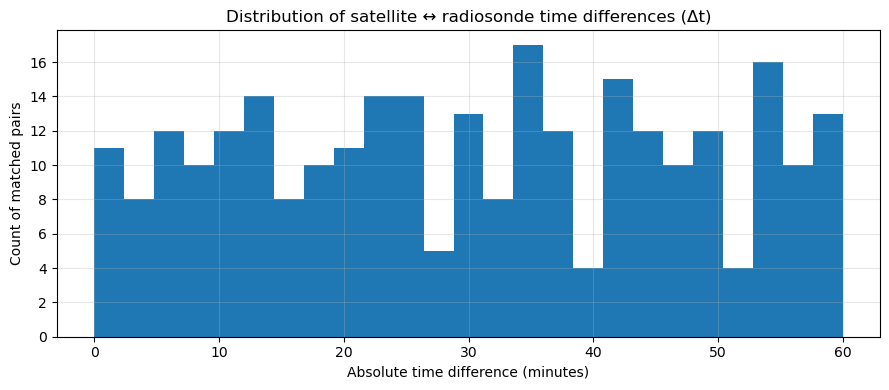

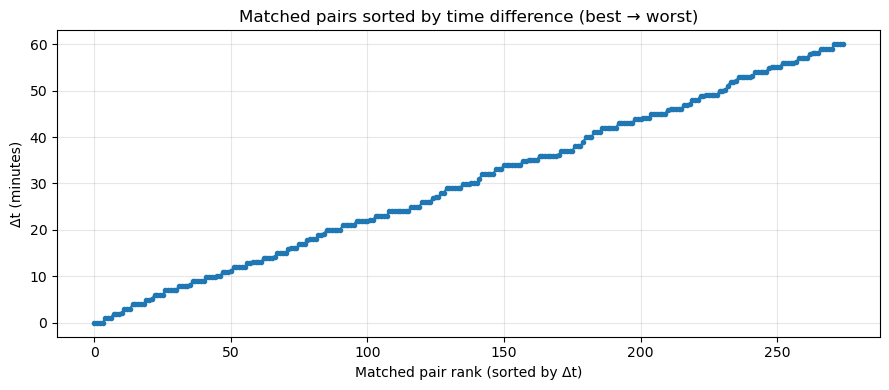

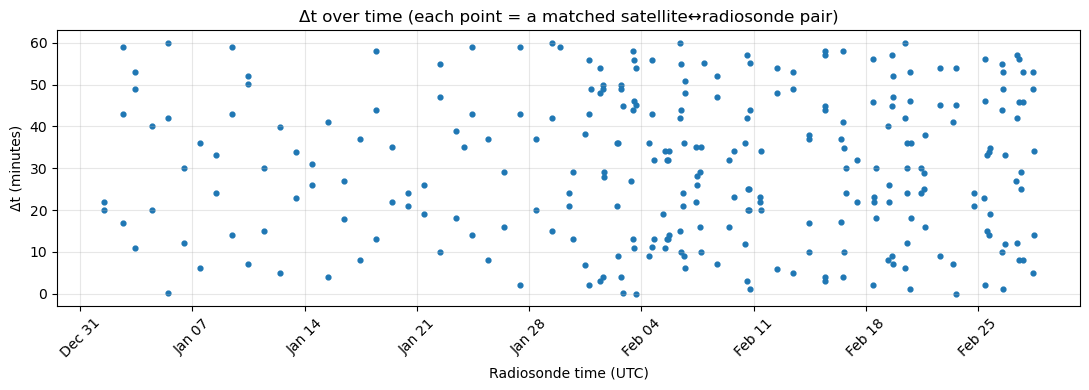


✅ Best match per radiosonde (preview):


radiosonde_time_utc                                     satellite_file  \
0  2025-01-01 11:01:00  IASI_SND_02_M03_20250101090552Z_20250101104456...   
1  2025-01-02 16:45:00  IASI_SND_02_M03_20250102152656Z_20250102170559...   
2  2025-01-03 10:52:00  IASI_SND_02_M01_20250103090558Z_20250103104757...   
3  2025-01-04 11:00:00  IASI_SND_02_M03_20250104094456Z_20250104112359...   
4  2025-01-05 10:59:00  IASI_SND_02_M03_20250105092359Z_20250105110255...   
5  2025-01-06 10:50:00  IASI_SND_02_M03_20250106090255Z_20250106104159...   
6  2025-01-07 10:53:00  IASI_SND_02_M01_20250107092357Z_20250107110557...   
7  2025-01-08 11:02:00  IASI_SND_02_M01_20250108090253Z_20250108104453...   
8  2025-01-09 11:00:00  IASI_SND_02_M03_20250109093855Z_20250109112054...   
9  2025-01-10 10:46:00  IASI_SND_02_M03_20250110091759Z_20250110105958...   
10 2025-01-11 10:47:00  IASI_SND_02_M03_20250111085655Z_20250111103854...   
11 2025-01-12 10:51:00  IASI_SND_02_M01_20250112092053Z_20250112110252...   
12 2025-01-13 10:58:00  IASI_SND_02_M01_20250113085957Z_20250113104156...   
13 2025-01-14 10:45:00  IASI_SND_02_M03_20250114093558Z_20250114111758...   
14 2025-01-15 10:54:00  IASI_SND_02_M03_20250115091454Z_20250115105654...   
15 2025-01-16 10:56:00  IASI_SND_02_M01_20250116093852Z_20250116112052...   
16 2025-01-17 10:45:00  IASI_SND_02_M01_20250117091757Z_20250117105956...   
17 2025-01-18 10:45:00  IASI_SND_02_M01_20250118085652Z_20250118103852...   
18 2025-01-19 10:46:00  IASI_SND_02_M03_20250119093254Z_20250119111453...   
19 2025-01-20 11:11:00  IASI_SND_02_M01_20250120095700Z_20250120113555...   

   sat_time_filename_utc sat_time_after_offset_utc  time_diff_minutes  
0    2025-01-01 09:05:52       2025-01-01 10:40:56          20.066667  
1    2025-01-02 15:26:56       2025-01-02 17:02:00          17.000000  
2    2025-01-03 09:05:58       2025-01-03 10:41:02          10.966667  
3    2025-01-04 09:44:56       2025-01-04 11:20:00          20.000000  
4    2025-01-05 09:23:59       2025-01-05 10:59:03           0.050000  
5    2025-01-06 09:02:55       2025-01-06 10:37:59          12.016667  
6    2025-01-07 09:23:57       2025-01-07 10:59:01           6.016667  
7    2025-01-08 09:02:53       2025-01-08 10:37:57          24.050000  
8    2025-01-09 09:38:55       2025-01-09 11:13:59          13.983333  
9    2025-01-10 09:17:59       2025-01-10 10:53:03           7.050000  
10   2025-01-11 08:56:55       2025-01-11 10:31:59          15.016667  
11   2025-01-12 09:20:53       2025-01-12 10:55:57           4.950000  
12   2025-01-13 08:59:57       2025-01-13 10:35:01          22.983333  
13   2025-01-14 09:35:58       2025-01-14 11:11:02          26.033333  
14   2025-01-15 09:14:54       2025-01-15 10:49:58           4.033333  
15   2025-01-16 09:38:52       2025-01-16 11:13:56          17.933333  
16   2025-01-17 09:17:57       2025-01-17 10:53:01           8.016667  
17   2025-01-18 08:56:52       2025-01-18 10:31:56          13.066667  
18   2025-01-19 09:32:54       2025-01-19 11:07:58          21.966667  
19   2025-01-20 09:57:00       2025-01-20 11:32:04          21.066667

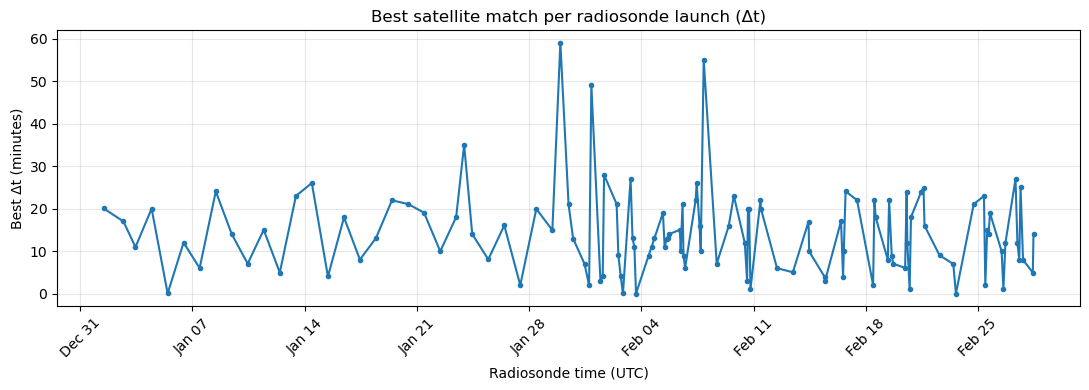

In [73]:
### duplicate

from datetime import datetime, timedelta
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

 
# ---------------------------------------------------
# CONSTANTS
# ---------------------------------------------------
TIME_OFFSET   = timedelta(hours=1, minutes=35, seconds=4)  # add to filename time
MATCH_WINDOW  = timedelta(hours=1)                         # ±1 hour matching window
 
# ---------------------------------------------------
# Query ALL satellite products (Jan 1 – Feb 28) using existing `collection`
# ---------------------------------------------------
start = datetime(2025, 1, 1, 0, 0)
end   = datetime(2025, 2, 28, 23, 59, 59)
 
products = list(collection.search(
    dtstart=start,
    dtend=end,
    bbox="11.921,78.923,11.922,78.924"
))
 
print("📡 Satellite files BEFORE filtering:", len(products))
 
# ---------------------------------------------------
# Helper: extract sensing start time from filename (YYYYMMDDHHMMSSZ)
# Example: ..._20250222183855Z_...
# ---------------------------------------------------
def extract_time_from_filename(name: str):
    m = re.search(r'_(\d{14})Z_', name)
    if not m:
        return None
    return datetime.strptime(m.group(1), "%Y%m%d%H%M%S")
 
# ---------------------------------------------------
# Match satellite ↔ radiosonde (store all matches)
# ---------------------------------------------------
rows = []
 
for product in products:
    sat_file = str(product)
 
    sat_time_from_filename = extract_time_from_filename(sat_file)
    if sat_time_from_filename is None:
        continue
 
    sat_time_after_offset = sat_time_from_filename + TIME_OFFSET
 
    for rs_time in radiosonde_times:
        diff = abs(sat_time_after_offset - rs_time)
        if diff <= MATCH_WINDOW:
            rows.append({
                "satellite_file": sat_file,
                "sat_time_filename_utc": sat_time_from_filename,
                "sat_time_after_offset_utc": sat_time_after_offset,
                "radiosonde_time_utc": rs_time,
                "time_diff_minutes": diff.total_seconds() / 60.0
            })
 
df = pd.DataFrame(rows)
 
print("\n📊 SUMMARY")
print("Satellite files BEFORE filtering :", len(products))
print("Matched pairs AFTER filtering    :", len(df))
 
if len(df) == 0:
    raise RuntimeError("No matches found. Check TIME_OFFSET, bbox, date range, or MATCH_WINDOW.")
 
# Sort: best matches first
df = df.sort_values("time_diff_minutes").reset_index(drop=True)
 
# Print a clean preview
print("\n📌 First 20 matched pairs (best → worst):\n")
display(df.head(20))
 
# Optional: save the full table
out_csv = "matched_pairs_jan_feb_2025.csv"
df.to_csv(out_csv, index=False)
print(f"\n✅ Saved full matched table to: {out_csv}")
 
# ---------------------------------------------------
# Better-looking visualizations (no custom colors)
# ---------------------------------------------------
 
# 1) Histogram of Δt
plt.figure(figsize=(9,4))
plt.hist(df["time_diff_minutes"], bins=25)
plt.xlabel("Absolute time difference (minutes)")
plt.ylabel("Count of matched pairs")
plt.title("Distribution of satellite ↔ radiosonde time differences (Δt)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
 
# 2) Sorted Δt line plot (best → worst)
plt.figure(figsize=(9,4))
plt.plot(df["time_diff_minutes"].values, marker="o", linestyle="-", markersize=3)
plt.xlabel("Matched pair rank (sorted by Δt)")
plt.ylabel("Δt (minutes)")
plt.title("Matched pairs sorted by time difference (best → worst)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
 
# 3) Timeline: radiosonde times vs satellite(actual) times
#    Shows how close they are over the full period.
plt.figure(figsize=(11,4))
plt.scatter(df["radiosonde_time_utc"], df["time_diff_minutes"], s=12)
plt.xlabel("Radiosonde time (UTC)")
plt.ylabel("Δt (minutes)")
plt.title("Δt over time (each point = a matched satellite↔radiosonde pair)")
plt.grid(True, alpha=0.3)
 
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
 
# 4) (Optional) For each radiosonde time, keep only the single BEST satellite match
best_per_rs = df.sort_values("time_diff_minutes").groupby("radiosonde_time_utc", as_index=False).first()
print("\n✅ Best match per radiosonde (preview):")
display(best_per_rs.head(20))
 
plt.figure(figsize=(11,4))
plt.plot(best_per_rs["radiosonde_time_utc"], best_per_rs["time_diff_minutes"], marker="o", linestyle="-", markersize=3)
plt.xlabel("Radiosonde time (UTC)")
plt.ylabel("Best Δt (minutes)")
plt.title("Best satellite match per radiosonde launch (Δt)")
plt.grid(True, alpha=0.3)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
######### downloading ALL THE files for test #####

In [37]:
# ============================================================
# STEP B — Download ALL matched satellite files
# ============================================================
 
import os
from pathlib import Path
 
# Folder to save
datapath = r"E:/METFUT/METFUT_01.01.26/"
os.makedirs(datapath, exist_ok=True)
 
# 1) Take ALL rows (pairs) exactly
df_pairs = df.sort_values("time_diff_minutes").reset_index(drop=True)
files_to_download = df_pairs["satellite_file"].tolist()
 
print("✅ Matched PAIRS (rows) to download:", len(files_to_download))
print("✅ Unique satellite files in these rows:", df_pairs["satellite_file"].nunique())
print("\nFirst 10 pairs to download:")
for i, f in enumerate(files_to_download[:10], 1):
    print(f"{i}. {f}")


✅ Matched PAIRS (rows) to download: 275
✅ Unique satellite files in these rows: 265

First 10 pairs to download:
1. IASI_SND_02_M03_20250203142356Z_20250203160259Z_N_O_20250203160459Z
2. IASI_SND_02_M01_20250223131455Z_20250223145655Z_N_O_20250223141236Z
3. IASI_SND_02_M01_20250202185058Z_20250202202954Z_N_O_20250202194442Z
4. IASI_SND_02_M03_20250105092359Z_20250105110255Z_N_O_20250105110454Z
5. IASI_SND_02_M01_20250220155656Z_20250220173855Z_N_O_20250220165825Z
6. IASI_SND_02_M01_20250226121455Z_20250226135359Z_N_O_20250226131534Z
7. IASI_SND_02_M01_20250210174457Z_20250210192657Z_N_O_20250210184046Z
8. IASI_SND_02_M01_20250131161154Z_20250131175058Z_N_O_20250131170759Z
9. IASI_SND_02_M01_20250225091455Z_20250225105359Z_N_O_20250225100922Z
10. IASI_SND_02_M01_20250127091155Z_20250127105354Z_N_O_20250127101304Z


In [39]:
# ============================================================
# STEP B — Download ALL FILES
# ============================================================
 
import os
from pathlib import Path
 
# Folder to save
datapath = r"E:/METFUT/METFUT_01.01.26/"
os.makedirs(datapath, exist_ok=True)
 
# 1) Take ALL rows (pairs) exactly
df_pairs = df.sort_values("time_diff_minutes").reset_index(drop=True)
files_to_download = df_pairs["satellite_file"].tolist()
 
print("✅ Matched PAIRS (rows) to download:", len(files_to_download))
print("✅ Unique satellite files in these rows:", df_pairs["satellite_file"].nunique())
print("\nFirst 10 pairs to download:")
for i, f in enumerate(files_to_download[:10], 1):
    print(f"{i}. {f}")
 
# 2) Helper: rename output to avoid overwriting (add pair index)
def with_pair_suffix(original_filename: str, pair_idx: int) -> str:
    p = Path(original_filename)
    # e.g., W_...eps_o_l2.nc  ->  W_...eps_o_l2__pair0001.nc
    return f"{p.stem}__pair{pair_idx:04d}{p.suffix}"
 
iasi_fns = []
 
# 3) Download loop
for i, product_id in enumerate(files_to_download, 1):
    print(f"\n({i}/{len(files_to_download)}) Downloading pair #{i}")
    print("Product:", product_id)
 
    token = get_token(consumer_key, consumer_secret)
    datastore, _ = get_datastore_collection(token)
 
    # This downloads the file and returns stream.name (original output filename)
    out_name = download_customized_product(
        datastore=datastore,
        product_id=product_id,
        collection_id=collection_id,
        token=token,
        product_id_short=collection_id_short,
        format_iasi=format_iasi
    )
 
    # 4) Rename the downloaded file to include the pair index (prevents overwrite)
    src = Path(datapath) / out_name
    dst = Path(datapath) / with_pair_suffix(out_name, i)
 
    # If the src file exists, rename it
    if src.exists():
        # If dst already exists for some reason, skip renaming to avoid crash
        if not dst.exists():
            src.rename(dst)
            iasi_fns.append(str(dst))
        else:
            # fallback: keep src as-is
            iasi_fns.append(str(src))
    else:
        print("⚠️ Warning: downloaded file not found on disk:", src)
        iasi_fns.append(out_name)
 
print("\n✅ DOWNLOAD COMPLETE")
print("Total downloaded outputs saved:", len(iasi_fns))
print("Saved to folder:", datapath)

✅ Matched PAIRS (rows) to download: 275
✅ Unique satellite files in these rows: 265

First 10 pairs to download:
1. IASI_SND_02_M03_20250203142356Z_20250203160259Z_N_O_20250203160459Z
2. IASI_SND_02_M01_20250223131455Z_20250223145655Z_N_O_20250223141236Z
3. IASI_SND_02_M01_20250202185058Z_20250202202954Z_N_O_20250202194442Z
4. IASI_SND_02_M03_20250105092359Z_20250105110255Z_N_O_20250105110454Z
5. IASI_SND_02_M01_20250220155656Z_20250220173855Z_N_O_20250220165825Z
6. IASI_SND_02_M01_20250226121455Z_20250226135359Z_N_O_20250226131534Z
7. IASI_SND_02_M01_20250210174457Z_20250210192657Z_N_O_20250210184046Z
8. IASI_SND_02_M01_20250131161154Z_20250131175058Z_N_O_20250131170759Z
9. IASI_SND_02_M01_20250225091455Z_20250225105359Z_N_O_20250225100922Z
10. IASI_SND_02_M01_20250127091155Z_20250127105354Z_N_O_20250127101304Z

(1/275) Downloading pair #1
Product: IASI_SND_02_M03_20250203142356Z_20250203160259Z_N_O_20250203160459Z
Token valid until: 2025-12-31 16:45:37.053118
Collection loaded: IASI 

ConnectionError: HTTPSConnectionPool(host='api.eumetsat.int', port=443): Max retries exceeded with url: /epcs/customisations/3d6c1fe5 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000002053CA26FF0>: Failed to resolve 'api.eumetsat.int' ([Errno 11001] getaddrinfo failed)"))

In [ ]:
# ============================================================
# STEP B — Download ALL matched satellite files (ALL pairs)
# Fixes:
# - creates subfolders if DataTailor returns "folder/file.nc"
# - supports resume
# - skips already downloaded files
# ============================================================
 
import os
import time
import fnmatch
import shutil
from pathlib import Path
 
# -------------------------
# OUTPUT FOLDER
# -------------------------
datapath = Path(r"E:/METFUT/METFUT_01.01.26/")
datapath.mkdir(parents=True, exist_ok=True)
 
# -------------------------
# RESUME CONTROL
# If it failed at pair 137, set START_PAIR = 138 and run again.
# -------------------------
START_PAIR = 1
 
# -------------------------
# ALL matched pairs from Part A
# df must exist
# -------------------------
df_pairs = df.sort_values("time_diff_minutes").reset_index(drop=True)
files_to_download = df_pairs["satellite_file"].tolist()
 
print("✅ Matched PAIRS (rows) to download:", len(files_to_download))
print("✅ Unique satellite files:", df_pairs["satellite_file"].nunique())
print("✅ Saving to:", datapath)
 
# -------------------------
# Download function (SAFE for subfolders in stream.name)
# -------------------------
def download_customized_product(datastore, product_id, token,
                                collection_id=collection_id,
                                product_id_short=collection_id_short,
                                format_iasi=format_iasi):
    """
    Downloads ONE tailored product and returns the relative nc name that Tailor produced.
    Tailor may return paths like: 'IASISND02--xxxx/W_XX-....nc'
    """
    selected_product = datastore.get_product(product_id=product_id, collection_id=collection_id)
 
    datatailor = eumdac.DataTailor(token)
    chain = eumdac.tailor_models.Chain(product=product_id_short, format=format_iasi)
    customisation = datatailor.new_customisation(selected_product, chain)
 
    # wait until done
    while True:
        status = customisation.status
        if "DONE" in status:
            nc_name = fnmatch.filter(customisation.outputs, "*.nc")[0]  # may include subfolder
            out_path = datapath / nc_name
 
            # ✅ FIX: ensure subfolders exist
            out_path.parent.mkdir(parents=True, exist_ok=True)
 
            with customisation.stream_output(nc_name) as stream, open(out_path, "wb") as fdst:
                shutil.copyfileobj(stream, fdst)
 
            return nc_name  # relative path from Tailor
        elif status in ["ERROR", "FAILED", "DELETED", "KILLED", "INACTIVE"]:
            raise RuntimeError(f"Tailor failed for {product_id}. Log:\n{customisation.logfile}")
        else:
            time.sleep(30)
 
# -------------------------
# rename helper (use only filename, avoid subfolder issues)
# -------------------------
def rename_with_pair_suffix(nc_relative_name: str, pair_idx: int) -> Path:
    p = Path(nc_relative_name)
    # always rename into root datapath, regardless of Tailor subfolder
    new_name = f"{p.stem}__pair{pair_idx:04d}{p.suffix}"
    return datapath / new_name
 
# -------------------------
# MAIN DOWNLOAD LOOP
# -------------------------
downloaded = 0
skipped = 0
 
for pair_idx in range(START_PAIR, len(files_to_download) + 1):
    product_id = files_to_download[pair_idx - 1]
    print(f"\n({pair_idx}/{len(files_to_download)}) Downloading pair #{pair_idx}")
    print("Product:", product_id)
 
    # if already downloaded (by suffix name), skip
    expected_out = rename_with_pair_suffix("dummy.nc", pair_idx).name  # just to check pair index suffix
    already = list(datapath.glob(f"*__pair{pair_idx:04d}.nc"))
    if len(already) > 0:
        print("✅ Already exists, skipping:", already[0].name)
        skipped += 1
        continue
 
    try:
        token = get_token(consumer_key, consumer_secret)
        datastore, _ = get_datastore_collection(token)
 
        nc_rel = download_customized_product(datastore=datastore, product_id=product_id, token=token)
 
        # Tailor may put it in subfolder; locate the actual saved file:
        src_path = datapath / nc_rel
        if not src_path.exists():
            raise FileNotFoundError(f"Expected downloaded file not found on disk: {src_path}")
 
        dst_path = rename_with_pair_suffix(nc_rel, pair_idx)
 
        # move/rename into root datapath
        if not dst_path.exists():
            src_path.replace(dst_path)
            print("✅ Saved as:", dst_path.name)
        else:
            print("⚠️ Destination already exists, keeping:", dst_path.name)
 
        downloaded += 1
 
    except Exception as e:
        print("\n❌ Stopping on error.")
        print("   Pair index:", pair_idx)
        print("   Product:", product_id)
        print("   Error:", repr(e))
        print("\n✅ To resume: set START_PAIR =", pair_idx, "and run this cell again.")
        break
 
print("\n✅ DONE (so far)")
print("Downloaded this run:", downloaded)
print("Skipped (already existed):", skipped)
print("Folder:", str(datapath))
 

✅ Matched PAIRS (rows) to download: 275
✅ Unique satellite files: 265
✅ Saving to: E:\METFUT\METFUT_01.01.26

(1/275) Downloading pair #1
Product: IASI_SND_02_M03_20250203142356Z_20250203160259Z_N_O_20250203160459Z
✅ Already exists, skipping: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPC+IASI_C_EUMP_20250203142356_32400_eps_o_l2__pair0001.nc

(2/275) Downloading pair #2
Product: IASI_SND_02_M01_20250223131455Z_20250223145655Z_N_O_20250223141236Z
✅ Already exists, skipping: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250223131455_64526_eps_o_l2__pair0002.nc

(3/275) Downloading pair #3
Product: IASI_SND_02_M01_20250202185058Z_20250202202954Z_N_O_20250202194442Z
✅ Already exists, skipping: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250202185058_64231_eps_o_l2__pair0003.nc

(4/275) Downloading pair #4
Product: IASI_SND_02_M03_20250105092359Z_20250105110255Z_N_O_20250105110454Z
✅ Already exists, skipping: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SO

In [48]:
# ============================================================
# STEP B — Download ALL matched satellite files (ALL pairs)
# Fixes:
# - creates subfolders if DataTailor returns "folder/file.nc"
# - supports resume
# - skips already downloaded files
# ============================================================
 
import os
import time
import fnmatch
import shutil
from pathlib import Path
 
# -------------------------
# OUTPUT FOLDER
# -------------------------
datapath = Path(r"E:/METFUT/METFUT_01.01.26/")
datapath.mkdir(parents=True, exist_ok=True)
 
# -------------------------
# RESUME CONTROL
# If it failed at pair 137, set START_PAIR = 138 and run again.
# -------------------------
START_PAIR = 1
 
# -------------------------
# ALL matched pairs from Part A
# df must exist
# -------------------------
df_pairs = df.sort_values("time_diff_minutes").reset_index(drop=True)
files_to_download = df_pairs["satellite_file"].tolist()
 
print("✅ Matched PAIRS (rows) to download:", len(files_to_download))
print("✅ Unique satellite files:", df_pairs["satellite_file"].nunique())
print("✅ Saving to:", datapath)
 
# -------------------------
# Download function (SAFE for subfolders in stream.name)
# -------------------------
def download_customized_product(datastore, product_id, token,
                                collection_id=collection_id,
                                product_id_short=collection_id_short,
                                format_iasi=format_iasi):
    """
    Downloads ONE tailored product and returns the relative nc name that Tailor produced.
    Tailor may return paths like: 'IASISND02--xxxx/W_XX-....nc'
    """
    selected_product = datastore.get_product(product_id=product_id, collection_id=collection_id)
 
    datatailor = eumdac.DataTailor(token)
    chain = eumdac.tailor_models.Chain(product=product_id_short, format=format_iasi)
    customisation = datatailor.new_customisation(selected_product, chain)
 
    # wait until done
    while True:
        status = customisation.status
        if "DONE" in status:
            nc_name = fnmatch.filter(customisation.outputs, "*.nc")[0]  # may include subfolder
            out_path = datapath / nc_name
 
            # ✅ FIX: ensure subfolders exist
            out_path.parent.mkdir(parents=True, exist_ok=True)
 
            with customisation.stream_output(nc_name) as stream, open(out_path, "wb") as fdst:
                shutil.copyfileobj(stream, fdst)
 
            return nc_name  # relative path from Tailor
        elif status in ["ERROR", "FAILED", "DELETED", "KILLED", "INACTIVE"]:
            raise RuntimeError(f"Tailor failed for {product_id}. Log:\n{customisation.logfile}")
        else:
            time.sleep(30)
 
# -------------------------
# rename helper (use only filename, avoid subfolder issues)
# -------------------------
def rename_with_pair_suffix(nc_relative_name: str, pair_idx: int) -> Path:
    p = Path(nc_relative_name)
    # always rename into root datapath, regardless of Tailor subfolder
    new_name = f"{p.stem}__pair{pair_idx:04d}{p.suffix}"
    return datapath / new_name
 
# -------------------------
# MAIN DOWNLOAD LOOP
# -------------------------
downloaded = 0
skipped = 0
 
for pair_idx in range(START_PAIR, len(files_to_download) + 1):
    product_id = files_to_download[pair_idx - 1]
    print(f"\n({pair_idx}/{len(files_to_download)}) Downloading pair #{pair_idx}")
    print("Product:", product_id)
 
    # if already downloaded (by suffix name), skip
    expected_out = rename_with_pair_suffix("dummy.nc", pair_idx).name  # just to check pair index suffix
    already = list(datapath.glob(f"*__pair{pair_idx:04d}.nc"))
    if len(already) > 0:
        print("✅ Already exists, skipping:", already[0].name)
        skipped += 1
        continue
 
    try:
        token = get_token(consumer_key, consumer_secret)
        datastore, _ = get_datastore_collection(token)
 
        nc_rel = download_customized_product(datastore=datastore, product_id=product_id, token=token)
 
        # Tailor may put it in subfolder; locate the actual saved file:
        src_path = datapath / nc_rel
        if not src_path.exists():
            raise FileNotFoundError(f"Expected downloaded file not found on disk: {src_path}")
 
        dst_path = rename_with_pair_suffix(nc_rel, pair_idx)
 
        # move/rename into root datapath
        if not dst_path.exists():
            src_path.replace(dst_path)
            print("✅ Saved as:", dst_path.name)
        else:
            print("⚠️ Destination already exists, keeping:", dst_path.name)
 
        downloaded += 1
 
    except Exception as e:
        print("\n❌ Stopping on error.")
        print("   Pair index:", pair_idx)
        print("   Product:", product_id)
        print("   Error:", repr(e))
        print("\n✅ To resume: set START_PAIR =", pair_idx, "and run this cell again.")
        break
 
print("\n✅ DONE (so far)")
print("Downloaded this run:", downloaded)
print("Skipped (already existed):", skipped)
print("Folder:", str(datapath))
 

✅ Matched PAIRS (rows) to download: 275
✅ Unique satellite files: 265
✅ Saving to: E:\METFUT\METFUT_01.01.26

(1/275) Downloading pair #1
Product: IASI_SND_02_M03_20250203142356Z_20250203160259Z_N_O_20250203160459Z
✅ Already exists, skipping: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPC+IASI_C_EUMP_20250203142356_32400_eps_o_l2__pair0001.nc

(2/275) Downloading pair #2
Product: IASI_SND_02_M01_20250223131455Z_20250223145655Z_N_O_20250223141236Z
✅ Already exists, skipping: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250223131455_64526_eps_o_l2__pair0002.nc

(3/275) Downloading pair #3
Product: IASI_SND_02_M01_20250202185058Z_20250202202954Z_N_O_20250202194442Z
✅ Already exists, skipping: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250202185058_64231_eps_o_l2__pair0003.nc

(4/275) Downloading pair #4
Product: IASI_SND_02_M03_20250105092359Z_20250105110255Z_N_O_20250105110454Z
✅ Already exists, skipping: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SO

In [ ]:
######### COMBINING ALL DOWNLOADED 275 FILES INTO ONE NC FILE ######

In [2]:
# ============================================================
# COMBINE ALL 275 IASI FILES INTO ONE NC (ALL VARIABLES)
# Extract EVERYTHING at nearest grid point to Ny-Ålesund
# (keeps vertical dims like nlq, pressure levels, etc.)
# ============================================================
 
import os
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
 
# -----------------------------
# SETTINGS
# -----------------------------
DATAPATH = r"E:/METFUT/METFUT_01.01.26/"   # folder containing *__pairXXXX.nc
OUTFILE  = os.path.join(DATAPATH, "COMBINED_IASI_NYA_ALL275_ALLVARS_NEARESTPOINT.nc")
 
ny_lat = 78.923
ny_lon = 11.921
EPOCH = datetime(2000, 1, 1, 0, 0, 0)
 
# -----------------------------
# Helpers
# -----------------------------
def find_first_existing(ds, candidates):
    for c in candidates:
        if c in ds.variables:
            return c
    return None
 
def nearest_grid_index(lat2d, lon2d, target_lat, target_lon):
    dist2 = (lat2d - target_lat)**2 + (lon2d - target_lon)**2
    i, j = np.unravel_index(np.argmin(dist2), dist2.shape)
    return int(i), int(j)
 
def safe_to_numpy(da):
    """Convert DataArray to numpy safely (avoid object types when possible)."""
    arr = da.values
    try:
        return np.array(arr)
    except Exception:
        return arr
 
# -----------------------------
# Collect files (only pair-indexed)
# -----------------------------
files = sorted([f for f in os.listdir(DATAPATH) if f.lower().endswith(".nc") and "__pair" in f.lower()])
print("✅ Found pair-indexed .nc files:", len(files))
print("First 10:")
for f in files[:10]:
    print("-", f)
 
if len(files) == 0:
    raise RuntimeError("No *__pairXXXX.nc files found. Check DATAPATH.")
 
# -----------------------------
# Main storage
# We'll build a dict:
#   var_name -> list of numpy arrays (one per case)
# and a dict:
#   var_name -> (dims_after_selection)
# -----------------------------
var_store = {}
var_dims  = {}
meta = {
    "file": [],
    "nearest_along_track": [],
    "nearest_across_track": [],
    "nearest_lat": [],
    "nearest_lon": [],
    "overpass_time_utc_str": [],
}
 
# For tracking dimension sizes (non-case dims)
dim_sizes = {}
 
# -----------------------------
# Loop through files
# -----------------------------
for idx, fn in enumerate(files, 1):
    fp = os.path.join(DATAPATH, fn)
    print(f"\n({idx}/{len(files)}) Processing:", fn)
 
    ds = xr.open_dataset(fp, decode_times=False)
 
    # detect lat/lon
    lat_name = find_first_existing(ds, ["lat", "latitude", "LATITUDE", "Latitude"])
    lon_name = find_first_existing(ds, ["lon", "longitude", "LONGITUDE", "Longitude"])
 
    if lat_name is None or lon_name is None:
        print("⚠️ Skipping: lat/lon not found")
        ds.close()
        continue
 
    lat = ds[lat_name].values
    lon = ds[lon_name].values
 
    # nearest point indices
    i_min, j_min = nearest_grid_index(lat, lon, ny_lat, ny_lon)
 
    # overpass time (record_start_time along_track)
    overpass_str = ""
    if "record_start_time" in ds.variables:
        try:
            overpass_dt = EPOCH + timedelta(seconds=int(ds["record_start_time"].values[i_min]))
            overpass_str = str(overpass_dt)
        except Exception:
            overpass_str = ""
    else:
        overpass_str = ""
 
    # store metadata
    meta["file"].append(fn)
    meta["nearest_along_track"].append(i_min)
    meta["nearest_across_track"].append(j_min)
    meta["nearest_lat"].append(float(lat[i_min, j_min]))
    meta["nearest_lon"].append(float(lon[i_min, j_min]))
    meta["overpass_time_utc_str"].append(overpass_str)
 
    # ---- Extract ALL variables at nearest point (when applicable) ----
    for vname, da in ds.data_vars.items():
 
        # Start from original DataArray
        x = da
 
        # If variable has along/across dims, select nearest
        if "along_track" in x.dims:
            x = x.isel(along_track=i_min)
        if "across_track" in x.dims:
            x = x.isel(across_track=j_min)
 
        # After selection, x no longer has along/across
        # Remaining dims might be: nlq, pressure_level, wavelength, etc.
        dims_after = tuple(x.dims)  # e.g., ('nlq',) or () or ('nlq','something')
 
        # Convert to numpy
        arr = safe_to_numpy(x)
 
        # Initialize storage for this variable on first time
        if vname not in var_store:
            var_store[vname] = []
            var_dims[vname] = dims_after
 
            # Track dim sizes from first occurrence
            for d in dims_after:
                if d not in dim_sizes:
                    dim_sizes[d] = x.sizes[d]
                else:
                    # keep existing
                    pass
 
        # Check consistency: same dims_after as first time
        if var_dims[vname] != dims_after:
            # If inconsistent, skip this variable for this file (keeps dataset consistent)
            # (You can later fix these if needed)
            continue
 
        # Check shape consistency (for remaining dims)
        # Scalars have shape () => fine
        # Vectors should match dim sizes
        if len(dims_after) > 0:
            expected_shape = tuple(dim_sizes[d] for d in dims_after)
            if np.shape(arr) != expected_shape:
                # skip inconsistent shapes
                continue
 
        var_store[vname].append(arr)
 
    ds.close()
 
# -----------------------------
# Build combined Dataset
# Each var becomes: (case, *dims_after)
# -----------------------------
n_cases = len(meta["file"])
print("\n✅ Total cases kept:", n_cases)
 
if n_cases == 0:
    raise RuntimeError("No files processed successfully.")
 
out_vars = {}
 
# Add all extracted variables
for vname, arr_list in var_store.items():
    if len(arr_list) != n_cases:
        # some variable was skipped in some files => drop it to keep dataset clean
        continue
 
    dims_after = var_dims[vname]
    dims_full = ("case",) + dims_after
 
    data = np.stack(
        [np.asarray(a) if np.shape(a) != () else np.asarray(a).reshape(()) for a in arr_list],
        axis=0
    ) if len(dims_after) > 0 else np.array(arr_list)
 
    out_vars[vname] = (dims_full, data)
 
# Add metadata variables
out_vars["file_name"] = (("case",), np.array(meta["file"], dtype=str))
out_vars["nearest_along_track"] = (("case",), np.array(meta["nearest_along_track"], dtype=int))
out_vars["nearest_across_track"] = (("case",), np.array(meta["nearest_across_track"], dtype=int))
out_vars["nearest_lat"] = (("case",), np.array(meta["nearest_lat"], dtype=float))
out_vars["nearest_lon"] = (("case",), np.array(meta["nearest_lon"], dtype=float))
out_vars["overpass_time_utc_str"] = (("case",), np.array(meta["overpass_time_utc_str"], dtype=str))
 
coords = {"case": np.arange(n_cases)}
for d, sz in dim_sizes.items():
    coords[d] = np.arange(sz)
 
out = xr.Dataset(
    data_vars=out_vars,
    coords=coords,
    attrs={
        "description": "All IASI variables extracted at nearest grid point to Ny-Ålesund and combined across cases",
        "ny_alesund_lat": ny_lat,
        "ny_alesund_lon": ny_lon,
        "note": "along_track/across_track reduced to nearest point; remaining dims preserved (e.g., nlq). decode_times=False.",
    }
)
 
# Save
out.to_netcdf(OUTFILE)
 
print("\n✅ DONE")
print("Saved combined NetCDF:", OUTFILE)
print("Variables saved:", len(out.data_vars))
print("Example variables:", list(out.data_vars)[:25])
 

✅ Found pair-indexed .nc files: 275
First 10:
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250101094758_63771_eps_o_l2__pair0102.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250102142654_63788_eps_o_l2__pair0196.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250102160854_63789_eps_o_l2__pair0268.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250103090558_63799_eps_o_l2__pair0048.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250104084454_63813_eps_o_l2__pair0183.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250105082358_63827_eps_o_l2__pair0274.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250105100558_63828_eps_o_l2__pair0190.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250106094454_63842_eps_o_l2__pair0136.nc
- W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250107092357_63856_eps_

In [ ]:
#### Accessing the combined file

In [8]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
COMBINED_FILE = r"E:\METFUT\METFUT_01.01.26\COMBINED_IASI_NYA_ALL275_ALLVARS_NEARESTPOINT.nc"
 
ds_combined_file = xr.open_dataset(COMBINED_FILE)
print(ds_combined_file)

<xarray.Dataset> Size: 987kB
Dimensions:                         (case: 275, nl_co: 19, nl_hno3: 41,
                                     nl_o3: 41, nl_so2: 5, nlt: 101, nlq: 101,
                                     nlo: 101, new: 12, cloud_formations: 3,
                                     nerr: 102, nerrt: 406, nerrw: 171,
                                     nerro: 55, co_nbr: 119, neva_co: 10,
                                     neve_co: 190, hno3_nbr: 119,
                                     neva_hno3: 21, neve_hno3: 861,
                                     o3_nbr: 115, neva_o3: 21, neve_o3: 861)
Coordinates: (12/23)
  * case                            (case) int32 1kB 0 1 2 3 ... 271 272 273 274
  * nl_co                           (nl_co) int32 76B 0 1 2 3 4 ... 15 16 17 18
  * nl_hno3                         (nl_hno3) int32 164B 0 1 2 3 ... 37 38 39 40
  * nl_o3                           (nl_o3) int32 164B 0 1 2 3 4 ... 37 38 39 40
  * nl_so2                          (nl_so

In [10]:
ds_combined_file

<xarray.Dataset> Size: 987kB
Dimensions:                         (case: 275, nl_co: 19, nl_hno3: 41,
                                     nl_o3: 41, nl_so2: 5, nlt: 101, nlq: 101,
                                     nlo: 101, new: 12, cloud_formations: 3,
                                     nerr: 102, nerrt: 406, nerrw: 171,
                                     nerro: 55, co_nbr: 119, neva_co: 10,
                                     neve_co: 190, hno3_nbr: 119,
                                     neva_hno3: 21, neve_hno3: 861,
                                     o3_nbr: 115, neva_o3: 21, neve_o3: 861)
Coordinates: (12/23)
  * case                            (case) int32 1kB 0 1 2 3 ... 271 272 273 274
  * nl_co                           (nl_co) int32 76B 0 1 2 3 4 ... 15 16 17 18
  * nl_hno3                         (nl_hno3) int32 164B 0 1 2 3 ... 37 38 39 40
  * nl_o3                           (nl_o3) int32 164B 0 1 2 3 4 ... 37 38 39 40
  * nl_so2                          (nl_so2) int32 20B 0 1 2 3 4
  * nlt                             (nlt) int32 404B 0 1 2 3 4 ... 97 98 99 100
    ...                              ...
  * hno3_nbr                        (hno3_nbr) int32 476B 0 1 2 ... 116 117 118
  * neva_hno3                       (neva_hno3) int32 84B 0 1 2 3 ... 18 19 20
  * neve_hno3                       (neve_hno3) int32 3kB 0 1 2 ... 858 859 860
  * o3_nbr                          (o3_nbr) int32 460B 0 1 2 3 ... 112 113 114
  * neva_o3                         (neva_o3) int32 84B 0 1 2 3 ... 17 18 19 20
  * neve_o3                         (neve_o3) int32 3kB 0 1 2 3 ... 858 859 860
Data variables: (12/88)
    forli_layer_heights_co          (case, nl_co) uint16 10kB ...
    forli_layer_heights_hno3        (case, nl_hno3) uint16 23kB ...
    forli_layer_heights_o3          (case, nl_o3) uint16 23kB ...
    brescia_altitudes_so2           (case, nl_so2) uint16 3kB ...
    record_start_time               (case) int32 1kB ...
    record_stop_time                (case) int32 1kB ...
    ...                              ...
    file_name                       (case) <U105 116kB ...
    nearest_along_track             (case) int32 1kB ...
    nearest_across_track            (case) int32 1kB ...
    nearest_lat                     (case) float64 2kB ...
    nearest_lon                     (case) float64 2kB ...
    overpass_time_utc_str           (case) <U19 21kB ...
Attributes:
    description:     All IASI variables extracted at nearest grid point to Ny...
    ny_alesund_lat:  78.923
    ny_alesund_lon:  11.921
    note:            along_track/across_track reduced to nearest point; remai...

In [ ]:
### testing the combined file

In [18]:
##### Removing 5 bad satellites which are not near to Ny Alesund

import xarray as xr
import numpy as np
import pandas as pd
 
# ----------------------------
# INPUT / OUTPUT
# ----------------------------
COMBINED_FILE = r"E:\METFUT\METFUT_01.01.26\COMBINED_IASI_NYA_ALL275_ALLVARS_NEARESTPOINT.nc"
OUT_CLEAN     = r"E:\METFUT\METFUT_01.01.26\COMBINED_IASI_NYA_ALL275_CLEAN.nc"
OUT_BAD_CSV   = r"E:\METFUT\METFUT_01.01.26\bad_cases_list.csv"
 
# Ny-Ålesund (target)
NY_LAT = 78.923
NY_LON = 11.921
 
# ----------------------------
# Thresholds (tune if needed)
# ----------------------------
MAX_ABS_LAT_DIFF = 0.8   # degrees
MAX_ABS_LON_DIFF = 2.0   # degrees
 
# ----------------------------
# Load combined
# ----------------------------
ds = xr.open_dataset(COMBINED_FILE)
 
lat = ds["nearest_lat"].values.astype(float)
lon = ds["nearest_lon"].values.astype(float)
 
# Absolute diffs
dlat = np.abs(lat - NY_LAT)
dlon = np.abs(lon - NY_LON)
 
good = (dlat <= MAX_ABS_LAT_DIFF) & (dlon <= MAX_ABS_LON_DIFF)
bad_idx = np.where(~good)[0]
 
print("Total cases:", ds.dims["case"])
print("Good cases :", int(good.sum()))
print("Bad cases  :", int((~good).sum()))
 
# ----------------------------
# Show bad cases with filenames (if 'file' variable exists)
# ----------------------------
# Your combined file should have something like: ds["file"] or ds["file_name"].
# We'll detect it safely.
file_var = None
for cand in ["file", "filename", "file_name", "source_file"]:
    if cand in ds.variables:
        file_var = cand
        break
 
if file_var is None:
    print("\n⚠️ Could not find file name variable in combined dataset.")
    print("Variables available:", list(ds.variables))
else:
    bad_files = ds[file_var].isel(case=bad_idx).values
    bad_table = pd.DataFrame({
        "case_index": bad_idx,
        "file": [str(x) for x in bad_files],
        "nearest_lat": lat[bad_idx],
        "nearest_lon": lon[bad_idx],
        "abs_lat_diff": dlat[bad_idx],
        "abs_lon_diff": dlon[bad_idx],
    }).sort_values(["abs_lat_diff","abs_lon_diff"], ascending=False)
 
    print("\n❌ BAD CASES (preview):")
    display(bad_table.head(20))
 
    bad_table.to_csv(OUT_BAD_CSV, index=False)
    print("\n✅ Saved bad cases list to:", OUT_BAD_CSV)
 
# ----------------------------
# Save cleaned dataset
# ----------------------------
ds_clean = ds.isel(case=np.where(good)[0])
ds_clean.to_netcdf(OUT_CLEAN)
print("\n✅ Saved CLEAN combined file to:", OUT_CLEAN)
 
# Quick sanity check
print("\nCLEAN nearest_lat min/max:", float(ds_clean["nearest_lat"].min()), float(ds_clean["nearest_lat"].max()))
print("CLEAN nearest_lon min/max:", float(ds_clean["nearest_lon"].min()), float(ds_clean["nearest_lon"].max()))

Total cases: 275
Good cases : 270
Bad cases  : 5

❌ BAD CASES (preview):


C:\Users\User\AppData\Local\Temp\ipykernel_19444\3127802977.py:37: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Total cases:", ds.dims["case"])


case_index                                               file  nearest_lat  \
4         156  W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,ME...    30.195700   
3         155  W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,ME...    34.904301   
1          27  W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,ME...    87.809700   
2          36  W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,ME...    87.199997   
0          20  W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,ME...    85.207794   

   nearest_lon  abs_lat_diff  abs_lon_diff  
4       1.7743     48.727300       10.1467  
3      12.0020     44.018699        0.0810  
1      10.3657      8.886700        1.5553  
2      10.5204      8.276997        1.4006  
0      13.7543      6.284794        1.8333


✅ Saved bad cases list to: E:\METFUT\METFUT_01.01.26\bad_cases_list.csv

✅ Saved CLEAN combined file to: E:\METFUT\METFUT_01.01.26\COMBINED_IASI_NYA_ALL275_CLEAN.nc

CLEAN nearest_lat min/max: 78.25409698486328 79.45469665527344
CLEAN nearest_lon min/max: 10.698899269104004 13.139599800109863


In [20]:
### Accessing the clean dataset
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
COMBINED_FILE_CLEAN = r"E:\METFUT\METFUT_01.01.26\COMBINED_IASI_NYA_ALL275_CLEAN.nc"
 
ds_combined_file_clean = xr.open_dataset(COMBINED_FILE_CLEAN)
print(ds_combined_file_clean)

<xarray.Dataset> Size: 970kB
Dimensions:                         (case: 270, nl_co: 19, nl_hno3: 41,
                                     nl_o3: 41, nl_so2: 5, nlt: 101, nlq: 101,
                                     nlo: 101, new: 12, cloud_formations: 3,
                                     nerr: 102, nerrt: 406, nerrw: 171,
                                     nerro: 55, co_nbr: 119, neva_co: 10,
                                     neve_co: 190, hno3_nbr: 119,
                                     neva_hno3: 21, neve_hno3: 861,
                                     o3_nbr: 115, neva_o3: 21, neve_o3: 861)
Coordinates: (12/23)
  * case                            (case) int32 1kB 0 1 2 3 ... 271 272 273 274
  * nl_co                           (nl_co) int32 76B 0 1 2 3 4 ... 15 16 17 18
  * nl_hno3                         (nl_hno3) int32 164B 0 1 2 3 ... 37 38 39 40
  * nl_o3                           (nl_o3) int32 164B 0 1 2 3 4 ... 37 38 39 40
  * nl_so2                          (nl_so

In [22]:
ds_combined_file_clean

<xarray.Dataset> Size: 970kB
Dimensions:                         (case: 270, nl_co: 19, nl_hno3: 41,
                                     nl_o3: 41, nl_so2: 5, nlt: 101, nlq: 101,
                                     nlo: 101, new: 12, cloud_formations: 3,
                                     nerr: 102, nerrt: 406, nerrw: 171,
                                     nerro: 55, co_nbr: 119, neva_co: 10,
                                     neve_co: 190, hno3_nbr: 119,
                                     neva_hno3: 21, neve_hno3: 861,
                                     o3_nbr: 115, neva_o3: 21, neve_o3: 861)
Coordinates: (12/23)
  * case                            (case) int32 1kB 0 1 2 3 ... 271 272 273 274
  * nl_co                           (nl_co) int32 76B 0 1 2 3 4 ... 15 16 17 18
  * nl_hno3                         (nl_hno3) int32 164B 0 1 2 3 ... 37 38 39 40
  * nl_o3                           (nl_o3) int32 164B 0 1 2 3 4 ... 37 38 39 40
  * nl_so2                          (nl_so2) int32 20B 0 1 2 3 4
  * nlt                             (nlt) int32 404B 0 1 2 3 4 ... 97 98 99 100
    ...                              ...
  * hno3_nbr                        (hno3_nbr) int32 476B 0 1 2 ... 116 117 118
  * neva_hno3                       (neva_hno3) int32 84B 0 1 2 3 ... 18 19 20
  * neve_hno3                       (neve_hno3) int32 3kB 0 1 2 ... 858 859 860
  * o3_nbr                          (o3_nbr) int32 460B 0 1 2 3 ... 112 113 114
  * neva_o3                         (neva_o3) int32 84B 0 1 2 3 ... 17 18 19 20
  * neve_o3                         (neve_o3) int32 3kB 0 1 2 3 ... 858 859 860
Data variables: (12/88)
    forli_layer_heights_co          (case, nl_co) uint16 10kB ...
    forli_layer_heights_hno3        (case, nl_hno3) uint16 22kB ...
    forli_layer_heights_o3          (case, nl_o3) uint16 22kB ...
    brescia_altitudes_so2           (case, nl_so2) uint16 3kB ...
    record_start_time               (case) int32 1kB ...
    record_stop_time                (case) int32 1kB ...
    ...                              ...
    file_name                       (case) <U105 113kB ...
    nearest_along_track             (case) int32 1kB ...
    nearest_across_track            (case) int32 1kB ...
    nearest_lat                     (case) float64 2kB ...
    nearest_lon                     (case) float64 2kB ...
    overpass_time_utc_str           (case) <U19 21kB ...
Attributes:
    description:     All IASI variables extracted at nearest grid point to Ny...
    ny_alesund_lat:  78.923
    ny_alesund_lon:  11.921
    note:            along_track/across_track reduced to nearest point; remai...

In [36]:
# ============================================================
# BUILD ONE COMBINED NETCDF (ALL SWATH FILES) — CLEAN + EFFICIENT
# Keeps the essential functions from workflow:
# - parse filename time
# - find nearest grid point to Ny-Ålesund
# - record_start_time (seconds since 2000-01-01) -> UTC datetime
# Extracts:
# - atmospheric_water_vapor (main)
# - fg_atmospheric_water_vapor (FG fallback)
# - pressure_levels_humidity
# Saves one combined NetCDF.
# ============================================================


import os
import re
import numpy as np
import xarray as xr
from pathlib import Path
from datetime import datetime, timedelta


# -----------------------------
# SETTINGS
# -----------------------------
DATA_DIR = r"E:\METFUT\METFUT_01.01.26"
OUT_FILE = os.path.join(DATA_DIR, "COMBINED_IASI_NYA_ALL275_CLEAN.nc")
 
NY_LAT = 78.923
NY_LON = 11.921
 
EPOCH = datetime(2000, 1, 1, 0, 0, 0)
 
# -----------------------------
# HELPERS
# -----------------------------
def list_swath_nc_files(folder):
    """
    Return ONLY the raw tailored IASI swath files.
    These typically start with 'W_XX-' in your case.
    (This automatically skips your combined file like IASI_NYA_top10_profiles.nc)
    """
    files = []
    for f in os.listdir(folder):
        if f.lower().endswith(".nc") and f.startswith("W_XX-"):
            files.append(os.path.join(folder, f))
    files.sort()
    return files
 
def parse_filename_time_utc(filepath):
    """Extract YYYYMMDDHHMMSS from filename."""
    fname = os.path.basename(filepath)
    m = re.search(r'_(\d{14})_', fname)   # works for W_XX-..._20250222183855_...
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d%H%M%S")
    return None
 
def find_var_name(ds, candidates):
    for name in candidates:
        if name in ds.variables:
            return name
    raise KeyError(f"None of these variables found: {candidates}")
 
def find_nearest_grid_point(ds):
    lat_name = find_var_name(ds, ["lat", "latitude", "LATITUDE", "Latitude"])
    lon_name = find_var_name(ds, ["lon", "longitude", "LONGITUDE", "Longitude"])
 
    lat = ds[lat_name].values
    lon = ds[lon_name].values
 
    dist2 = (lat - NY_LAT)**2 + (lon - NY_LON)**2
    i_min, j_min = np.unravel_index(np.nanargmin(dist2), dist2.shape)
 
    return int(i_min), int(j_min), float(lat[i_min, j_min]), float(lon[i_min, j_min]), lat_name, lon_name
 
def overpass_time_from_record_start(ds, along_index):
    """Professor method: epoch + record_start_time[along_index]."""
    if "record_start_time" not in ds.variables:
        return None
    try:
        sec_val = int(ds["record_start_time"].values[along_index])
        return EPOCH + timedelta(seconds=sec_val)
    except Exception:
        return None
 
# -----------------------------
# MAIN
# -----------------------------
nc_files = list_swath_nc_files(DATA_DIR)
 
print("✅ Found SWATH .nc files (excluding combined outputs):", len(nc_files))
for f in nc_files[:5]:
    print(" -", os.path.basename(f))
if len(nc_files) > 5:
    print(" ...")
 
all_wv_profiles = []
all_fgwv_profiles = []
all_pressure_profiles = []
all_times = []
all_file_times = []
all_files = []
all_orbit = []
all_near_lat = []
all_near_lon = []
pressure_levels = None
 
for idx, fpath in enumerate(nc_files, start=1):
    print(f"\n({idx}/{len(nc_files)}) Reading:", os.path.basename(fpath))
 
    ds = xr.open_dataset(fpath, decode_times=False)
 
    # nearest grid
    i_min, j_min, near_lat, near_lon, lat_name, lon_name = find_nearest_grid_point(ds)
 
    # pressure levels

    pressure_levels = ds["pressure_levels_humidity"]
    wv = ds["atmospheric_water_vapor"][i_min,j_min,:]
    fgwv = ds["fg_atmospheric_water_vapor"][i_min,j_min,:]

    


    
   ## if pressure_levels is None:
     ###   p_name = find_var_name(ds, ["pressure_levels_humidity", "pressure_levels", "pressure_level", "pressure"])
      ###  pressure_levels = ds[p_name].values.astype(float)
 
    # water vapour variable (as you already found)
    ## wv_name = find_var_name(ds, ["atmospheric_water_vapor", "water_vapour", "water_vapor", "humidity"])
    ## profile = ds[wv_name].isel(along_track=i_min, across_track=j_min).values.astype(float)
 
    # times
    overpass_time = overpass_time_from_record_start(ds, along_index=i_min)  # use i_min (nearest along track)
    file_time = parse_filename_time_utc(fpath)
 
    orbit_guess = None
    if file_time is not None:
        orbit_guess = "morning" if file_time.hour < 12 else "evening"
 
    # store
    all_wv_profiles.append(wv)
    all_fgwv_profiles.append(fgwv)
    all_pressure_profiles.append(pressure_levels)
    all_times.append(overpass_time)
    all_file_times.append(file_time)
    all_files.append(os.path.basename(fpath))
    all_orbit.append(orbit_guess)
    all_near_lat.append(near_lat)
    all_near_lon.append(near_lon)
 
    print("   nearest indices:", i_min, j_min, "| nearest lat/lon:", near_lat, near_lon)
    print("   file time:", file_time, "| overpass time:", overpass_time, "| orbit:", orbit_guess)
 
# Convert datetimes to numpy datetime64
def to_dt64(arr):
    out = []
    for t in arr:
        out.append(np.datetime64("NaT") if t is None else np.datetime64(t))
    return np.array(out)
 
combined = xr.Dataset(
    data_vars={
        "all_wv_profiles": (("time", "pressure_level"), all_wv_profiles),
        "all_fgwv_profiles": (("time", "pressure_level"), all_fgwv_profiles),
        "all_pressure_profiles": (("time", "pressure_level"), all_pressure_profiles),
        "nearest_lat": (("time",), np.array(all_near_lat, dtype=float)),
        "nearest_lon": (("time",), np.array(all_near_lon, dtype=float)),
    },
    coords={
        "time": to_dt64(all_times),
        "pressure_level": pressure_levels
    },
    attrs={
        "site_name": "Ny-Alesund",
        "site_lat": NY_LAT,
        "site_lon": NY_LON,
        "note": "Combined IASI water vapour profiles at nearest grid point to Ny-Alesund (swath files only).",
    }
)
 
combined = combined.assign_coords(
    file_name=("time", np.array(all_files, dtype=object)),
    file_time_utc=("time", to_dt64(all_file_times)),
    orbit_guess=("time", np.array(all_orbit, dtype=object)),
)
 
print("\n✅ Combined dataset created:")
print(combined)
 
combined.to_netcdf(OUT_FILE)
print("\n✅ Saved combined NetCDF here:\n", OUT_FILE)

✅ Found SWATH .nc files (excluding combined outputs): 275
 - W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250101094758_63771_eps_o_l2__pair0102.nc
 - W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250102142654_63788_eps_o_l2__pair0196.nc
 - W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250102160854_63789_eps_o_l2__pair0268.nc
 - W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250103090558_63799_eps_o_l2__pair0048.nc
 - W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250104084454_63813_eps_o_l2__pair0183.nc
 ...

(1/275) Reading: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250101094758_63771_eps_o_l2__pair0102.nc
   nearest indices: 722 65 | nearest lat/lon: 78.93930053710938 12.109299659729004
   file time: 2025-01-01 09:47:58 | overpass time: 2025-01-01 11:24:14 | orbit: morning

(2/275) Reading: W_XX-EUMETSAT-Darmstadt,HYPERSPECT+SOUNDING,METOPB+IASI_C_EUMP_20250102142654_6

C:\Users\User\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3577: SerializationWarning: saving variable pressure_levels_humidity with floating point data as an integer dtype without any _FillValue to use for NaNs
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\User\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3577: SerializationWarning: saving variable pressure_level with floating point data as an integer dtype without any _FillValue to use for NaNs
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
import os
DATA_DIR = r"E:\METFUT\METFUT_01.01.26"
OUT_FILE = os.path.join(DATA_DIR, "COMBINED_IASI_NYA_ALL275_CLEAN.nc")
ds2 = xr.open_dataset(OUT_FILE, decode_times=True)

In [40]:
ds2["all_wv_profiles"].values

array([[4.2949673e+02, 4.2949673e+02, 4.2949673e+02, ..., 4.2949673e+02,
        4.2949673e+02, 4.2949673e+02],
       [4.2949673e+02, 4.2949673e+02, 4.2949673e+02, ..., 4.2949673e+02,
        4.2949673e+02, 4.2949673e+02],
       [1.3000000e-06, 1.4000000e-06, 1.6000000e-06, ..., 4.2949673e+02,
        4.2949673e+02, 4.2949673e+02],
       ...,
       [4.2949673e+02, 4.2949673e+02, 4.2949673e+02, ..., 4.2949673e+02,
        4.2949673e+02, 4.2949673e+02],
       [4.2949673e+02, 4.2949673e+02, 4.2949673e+02, ..., 4.2949673e+02,
        4.2949673e+02, 4.2949673e+02],
       [4.2949673e+02, 4.2949673e+02, 4.2949673e+02, ..., 4.2949673e+02,
        4.2949673e+02, 4.2949673e+02]], dtype=float32)

In [31]:
ds2

<xarray.Dataset> Size: 466kB
Dimensions:                   (time: 275, pressure_level: 101, nlq: 101)
Coordinates:
    pressure_levels_humidity  (nlq) float32 404B ...
  * time                      (time) datetime64[ns] 2kB 2025-01-01T11:24:14 ....
    pressure_level            (nlq) float32 404B ...
    file_name                 (time) <U105 116kB ...
    file_time_utc             (time) datetime64[ns] 2kB ...
    orbit_guess               (time) <U7 8kB ...
Dimensions without coordinates: nlq
Data variables:
    all_wv_profiles           (time, pressure_level) float32 111kB ...
    all_fgwv_profiles         (time, pressure_level) float32 111kB ...
    all_pressure_profiles     (time, pressure_level) float32 111kB ...
    nearest_lat               (time) float64 2kB ...
    nearest_lon               (time) float64 2kB ...
Attributes:
    site_name:  Ny-Alesund
    site_lat:   78.923
    site_lon:   11.921
    note:       Combined IASI water vapour profiles at nearest grid point to ...

In [ ]:
############ RADIOSONDES ##############

In [42]:
#### ACCESSING RADIOSONDES FILE #####

import xarray as xr
import pandas as pd
import numpy as np
 
RADIOSONDE_FILE = r"E:\METFUT\radiosondes_data\rs_iop4h2o.nc"
 
# Open radiosonde file
rs = xr.open_dataset(RADIOSONDE_FILE, decode_times=True)
 
# ✅ FIX: time coordinate is called 'launchtime'
rs_time_name = "launchtime"
 
# Get radiosonde launch times
rs_times_raw = rs[rs_time_name].values
 
# Convert safely to pandas datetime (works if it's already datetime64 or if it's numeric but decoded)
rs_times = pd.to_datetime(rs_times_raw)
 
# Sort (important for nearest-time matching)
rs_times = pd.Series(rs_times).sort_values().reset_index(drop=True)
 
print("✅ Radiosonde time variable:", rs_time_name)
print("✅ Number of radiosonde launches:", len(rs_times))
print("First 5 launch times:", rs_times.head(5).to_list())

✅ Radiosonde time variable: launchtime
✅ Number of radiosonde launches: 208
First 5 launch times: [Timestamp('1970-01-01 00:03:22.501011101'), Timestamp('1970-01-01 00:03:22.501021645'), Timestamp('1970-01-01 00:03:22.501022249'), Timestamp('1970-01-01 00:03:22.501031052'), Timestamp('1970-01-01 00:03:22.501032245')]


✅ Radiosonde launches: 208
✅ First 5 launch times: [Timestamp('2025-01-01 11:01:00+0000', tz='UTC'), Timestamp('2025-01-02 16:45:00+0000', tz='UTC'), Timestamp('2025-01-02 22:49:00+0000', tz='UTC'), Timestamp('2025-01-03 10:52:00+0000', tz='UTC'), Timestamp('2025-01-03 22:45:00+0000', tz='UTC')]

✅ IASI profiles in combined file: 275
✅ First 3 IASI times: [Timestamp('2025-01-01 11:24:14+0000', tz='UTC'), Timestamp('2025-01-02 16:03:58+0000', tz='UTC'), Timestamp('2025-01-02 17:44:14+0000', tz='UTC')]

📊 MATCH SUMMARY
IASI times total                 : 275
Matched (<= 1 hour)              : 272


C:\Users\User\AppData\Local\Temp\ipykernel_19444\1495748794.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  MAX_DT = pd.Timedelta("1H")   # 1 hour window


sat_time_utc       radiosonde_time_utc  time_diff_minutes
0  2025-01-05 10:58:47+00:00 2025-01-05 10:59:00+00:00           0.216667
1  2025-02-03 15:59:24+00:00 2025-02-03 15:59:00+00:00           0.400000
2  2025-02-02 20:26:34+00:00 2025-02-02 20:26:00+00:00           0.566667
3  2025-02-18 10:48:18+00:00 2025-02-18 10:49:00+00:00           0.700000
4  2025-02-26 13:49:59+00:00 2025-02-26 13:51:00+00:00           1.016667
5  2025-02-20 17:34:08+00:00 2025-02-20 17:33:00+00:00           1.133333
6  2025-02-15 10:10:18+00:00 2025-02-15 10:12:00+00:00           1.700000
7  2025-01-31 17:46:42+00:00 2025-01-31 17:45:00+00:00           1.700000
8  2025-02-15 10:10:18+00:00 2025-02-15 10:12:00+00:00           1.700000
9  2025-02-01 10:45:14+00:00 2025-02-01 10:47:00+00:00           1.766667
10 2025-02-23 14:51:51+00:00 2025-02-23 14:50:00+00:00           1.850000
11 2025-02-10 19:20:57+00:00 2025-02-10 19:19:00+00:00           1.950000
12 2025-01-15 10:51:58+00:00 2025-01-15 10:54:00+00:00           2.033333
13 2025-02-25 10:50:15+00:00 2025-02-25 10:48:00+00:00           2.250000
14 2025-02-10 14:20:09+00:00 2025-02-10 14:17:00+00:00           3.150000

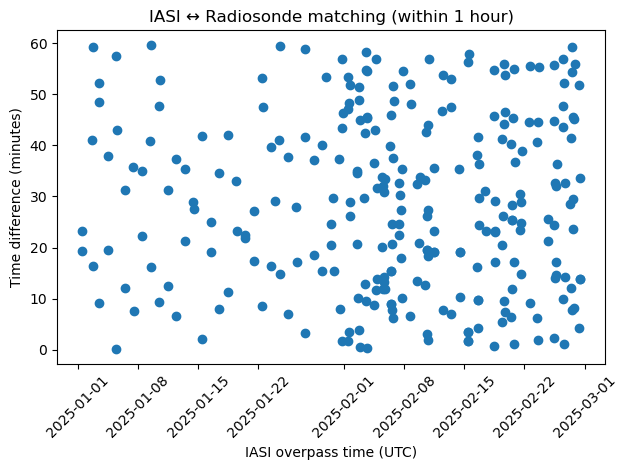

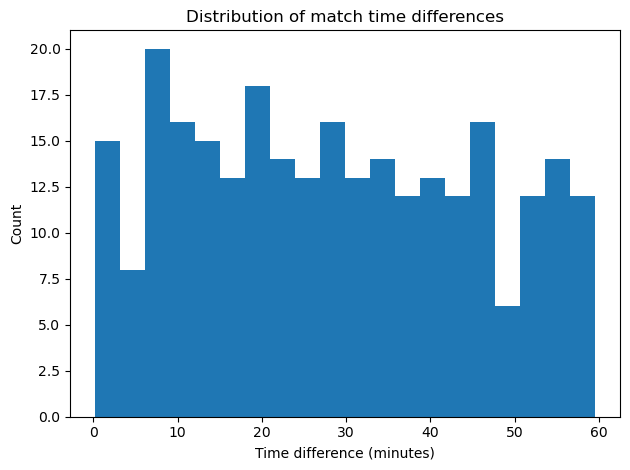

In [52]:
#### CONVERTING RADIOSONDES TIMES TO UTC

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
 
# ----------------------------
# PATHS (your paths)
# ----------------------------
IASI_COMBINED_FILE = r"E:\METFUT\METFUT_01.01.26\COMBINED_IASI_NYA_ALL275_CLEAN.nc"
RADIOSONDE_FILE    = r"E:\METFUT\radiosondes_data\rs_iop4h2o.nc"
 
# Matching rule
MAX_DT = pd.Timedelta("1H")   # 1 hour window
 
# ----------------------------
# 1) Read + FIX radiosonde launch times
# ----------------------------
rs = xr.open_dataset(RADIOSONDE_FILE, decode_times=False)
 
# launchtime is int64 like 202502221417 with units 'yyyymmddhhmm'
lt_raw = rs["launchtime"].values.astype(np.int64)
 
# Convert int -> string -> datetime (UTC)
lt_str = pd.Series(lt_raw).astype(str).str.zfill(12)
rs_times = pd.to_datetime(lt_str, format="%Y%m%d%H%M", utc=True)
 
print("✅ Radiosonde launches:", len(rs_times))
print("✅ First 5 launch times:", rs_times[:5].to_list())
 
# ----------------------------
# 2) Read combined IASI file + detect time coordinate
# ----------------------------
iasi = xr.open_dataset(IASI_COMBINED_FILE, decode_times=True)
 
# choose the time coordinate name (common: 'time')
time_coord_candidates = ["time", "overpass_time", "record_time", "record_start_time"]
iasi_time_name = None
for c in time_coord_candidates:
    if c in iasi.coords or c in iasi.data_vars:
        iasi_time_name = c
        break
 
if iasi_time_name is None:
    raise KeyError(f"Could not find IASI time variable in combined file. Found coords={list(iasi.coords)}, data_vars={list(iasi.data_vars)}")
 
# If the combined file stores "time" as datetime64 already, this will work:
iasi_times = pd.to_datetime(iasi[iasi_time_name].values)
 
# If it becomes timezone-naive, force UTC (safe for matching)
if iasi_times.tz is None:
    iasi_times = iasi_times.tz_localize("UTC")
 
print("\n✅ IASI profiles in combined file:", len(iasi_times))
print("✅ First 3 IASI times:", iasi_times[:3].to_list())
 
# ----------------------------
# 3) Match each IASI time to nearest radiosonde time (within 1 hour)
# ----------------------------
rs_series = pd.Series(rs_times).sort_values().reset_index(drop=True)
 
pairs = []
for sat_t in iasi_times:
    # find nearest radiosonde launch
    idx = np.argmin(np.abs((rs_series - sat_t).values.astype("timedelta64[s]").astype(np.int64)))
    nearest_rs = rs_series.iloc[idx]
    dt = abs(nearest_rs - sat_t)
 
    if dt <= MAX_DT:
        pairs.append({
            "sat_time_utc": sat_t,
            "radiosonde_time_utc": nearest_rs,
            "time_diff_minutes": dt.total_seconds()/60.0
        })
 
df = pd.DataFrame(pairs).sort_values("time_diff_minutes").reset_index(drop=True)
 
print("\n📊 MATCH SUMMARY")
print("IASI times total                 :", len(iasi_times))
print("Matched (<= 1 hour)              :", len(df))
display(df.head(15))
 
# ----------------------------
# 4) Simple “better looking” visualization
# ----------------------------
plt.figure()
plt.scatter(df["sat_time_utc"], df["time_diff_minutes"])
plt.ylabel("Time difference (minutes)")
plt.xlabel("IASI overpass time (UTC)")
plt.title("IASI ↔ Radiosonde matching (within 1 hour)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
 
plt.figure()
plt.hist(df["time_diff_minutes"], bins=20)
plt.xlabel("Time difference (minutes)")
plt.ylabel("Count")
plt.title("Distribution of match time differences")
plt.tight_layout()
plt.show()

✅ BEST match:
   IASI: 2025-01-05 10:58:47+00:00
   RS  : 2025-01-05 10:59:00+00:00
   Δt  : 0.21666666666666667 min

--- DIAGNOSTICS ---
IASI FG var: all_fgwv_profiles units: None
IASI q raw min/max: 1.2e-06 429.49673
IASI q g/kg min/max: 0.0012000000424450263 429496.7346191406
IASI p hPa min/max: 0.005 1100.0
RS q units: g/kg
RS q raw min/max: 0.002394931055369246 1.4895625220295807
RS q g/kg min/max: 0.002394931055369246 1.4895625220295807
RS p hPa min/max: 142.232 1012.18


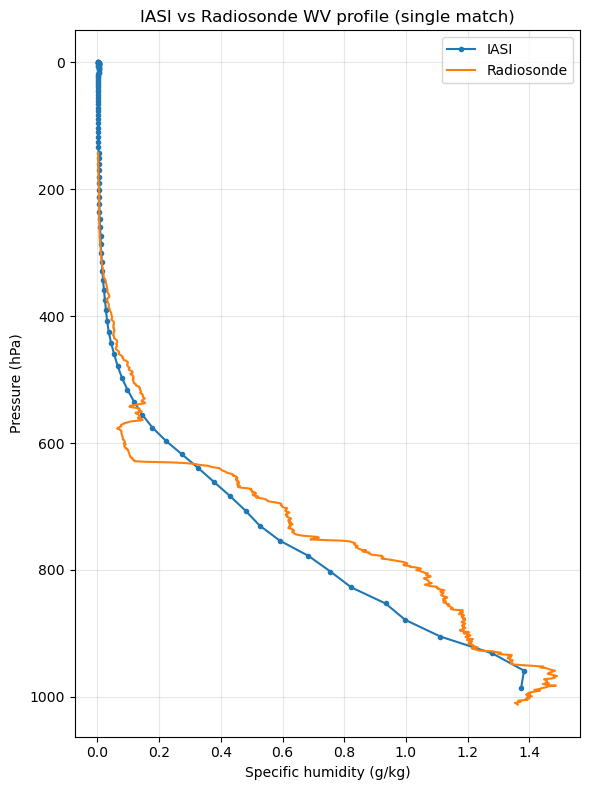

In [1]:
# ============================================================
# FIXED PLOT: IASI (FG) vs Radiosonde
# - robust unit handling (kg/kg vs g/kg vs mg/kg)
# - sanity checks + prints min/max
# - clips impossible values
# - plots a single match case study
# ============================================================
 
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
IASI_COMBINED_FILE = r"E:\METFUT\METFUT_01.01.26\COMBINED_IASI_NYA_ALL275_CLEAN.nc"
RADIOSONDE_FILE    = r"E:\METFUT\radiosondes_data\rs_iop4h2o.nc"
MAX_DT = pd.Timedelta("1h")
 
def first_existing(ds, names):
    for n in names:
        if n in ds.data_vars or n in ds.coords:
            return n
    return None
 
def find_iasi_time_coord(ds):
    cands = ["time", "overpass_time", "record_time", "overpass_time_utc", "time_utc"]
    for c in cands:
        if c in ds.coords or c in ds.data_vars:
            return c
    raise KeyError(f"No IASI time coord found. coords={list(ds.coords)} vars={list(ds.data_vars)}")
 
def find_iasi_fg_profile_var(ds):
    cands = [
        "all_fgwv_profiles",
        "fg_atmospheric_water_vapor_profile",
        "fg_atmospheric_water_vapor",
        "FG_ATMOSPHERICWATERVAPOUR",
    ]
    v = first_existing(ds, cands)
    if v is None:
        raise KeyError(f"No IASI FG WV var found. Tried {cands}. vars={list(ds.data_vars)}")
    return v
 
def find_pressure_var(ds, fg_var):
    # prefer 1D pressure coord/var
    for c in ["pressure_level", "pressure_levels_humidity", "pressure", "plev"]:
        if c in ds.coords or c in ds.data_vars:
            p = ds[c].values
            if np.ndim(p) == 1:
                return c, "1d"
    # else 2D pressure profile variable
    for c in ["all_pressure_profiles", "pressure_profile", "pressure_levels_humidity"]:
        if c in ds.data_vars:
            return c, "2d"
    # else infer from dim name
    dims = ds[fg_var].dims
    for d in dims:
        if "press" in d.lower():
            if d in ds.coords or d in ds.data_vars:
                return d, "1d"
    raise KeyError("No pressure variable found in combined file.")
 
def pressure_to_hpa(p):
    p = np.asarray(p, dtype=float)
    # Pa -> hPa if needed
    if np.nanmedian(p) > 2000:
        p = p / 100.0
    return p
 
def q_to_gpkg(q, units_attr=None):
    """
    Convert q to g/kg safely.
    Handles:
      - kg/kg  (typical <0.1) -> *1000
      - g/kg   (typical <30)  -> keep
      - mg/kg  (typical <30000) -> /1000
    Uses units attribute if available, else uses magnitude heuristics.
    """
    q = np.asarray(q, dtype=float)
 
    # If dataset has units info, trust it
    if units_attr is not None:
        u = str(units_attr).lower().replace(" ", "")
        if u in ["kg/kg", "kgkg-1", "kgkg^-1", "1"]:
            return q * 1000.0
        if u in ["g/kg", "gkg-1", "gkg^-1"]:
            return q
        if u in ["mg/kg", "mgkg-1", "mgkg^-1"]:
            return q / 1000.0
 
    # Otherwise: magnitude-based
    med = np.nanmedian(np.abs(q[np.isfinite(q)])) if np.any(np.isfinite(q)) else np.nan
 
    # kg/kg (0.0001 .. 0.05)
    if np.isfinite(med) and med < 0.2:
        return q * 1000.0
 
    # mg/kg (hundreds to tens of thousands)
    if np.isfinite(med) and med > 200:
        return q / 1000.0
 
    # likely already g/kg
    return q
 
def clean_profile(q_gpkg, p_hpa):
    q = np.asarray(q_gpkg, dtype=float)
    p = np.asarray(p_hpa, dtype=float)
 
    mask = np.isfinite(q) & np.isfinite(p) & (p > 0) & (p < 1100)
    q = q[mask]
    p = p[mask]
 
    # Remove impossible q (keep generous bounds)
    good = (q >= 0) & (q <= 50)
    q = q[good]
    p = p[good]
 
    # sort by pressure descending (surface first)
    order = np.argsort(p)[::-1]
    return q[order], p[order]
 
# ----------------------------
# Read radiosondes and build UTC times from launchtime int yyyymmddhhmm
# ----------------------------
rs = xr.open_dataset(RADIOSONDE_FILE, decode_times=False)
 
lt_raw = rs["launchtime"].values.astype(np.int64)
lt_str = pd.Series(lt_raw).astype(str).str.zfill(12)
rs_times = pd.to_datetime(lt_str, format="%Y%m%d%H%M", utc=True)
rs_series = pd.Series(rs_times).sort_values().reset_index(drop=True)
 
# ----------------------------
# Read IASI combined and get times
# ----------------------------
iasi = xr.open_dataset(IASI_COMBINED_FILE, decode_times=True)
iasi_time_name = find_iasi_time_coord(iasi)
 
iasi_times = pd.to_datetime(iasi[iasi_time_name].values)
if getattr(iasi_times, "tz", None) is None:
    iasi_times = iasi_times.tz_localize("UTC")
 
# ----------------------------
# Match each IASI time to nearest radiosonde time within 1 hour
# ----------------------------
pairs = []
for i_idx, sat_t in enumerate(iasi_times):
    dt_seconds = np.abs((rs_series - sat_t).values.astype("timedelta64[s]").astype(np.int64))
    rs_idx = int(np.argmin(dt_seconds))
    nearest_rs = rs_series.iloc[rs_idx]
    dt = abs(nearest_rs - sat_t)
    if dt <= MAX_DT:
        pairs.append({"iasi_index": i_idx, "radiosonde_index": rs_idx,
                      "sat_time_utc": sat_t, "radiosonde_time_utc": nearest_rs,
                      "time_diff_minutes": dt.total_seconds()/60.0})
df_match = pd.DataFrame(pairs).sort_values("time_diff_minutes").reset_index(drop=True)
 
if len(df_match) == 0:
    raise RuntimeError("No matches within 1 hour.")
 
best = df_match.iloc[0]
best_i = int(best["iasi_index"])
best_r = int(best["radiosonde_index"])
 
print("✅ BEST match:")
print("   IASI:", best["sat_time_utc"])
print("   RS  :", best["radiosonde_time_utc"])
print("   Δt  :", best["time_diff_minutes"], "min")
 
# ----------------------------
# Extract IASI FG profile + pressure
# ----------------------------
fg_var = find_iasi_fg_profile_var(iasi)
p_name, p_kind = find_pressure_var(iasi, fg_var)
 
fg_da = iasi[fg_var]
time_dim = fg_da.dims[0]  # usually time
 
q_i_raw = fg_da.isel({time_dim: best_i}).values.squeeze()
units_iasi = fg_da.attrs.get("units", None)
 
if p_kind == "2d":
    p_i_raw = iasi[p_name].isel({time_dim: best_i}).values.squeeze()
else:
    p_i_raw = iasi[p_name].values.squeeze()
 
q_i_gpkg = q_to_gpkg(q_i_raw, units_attr=units_iasi)
p_i_hpa  = pressure_to_hpa(p_i_raw)
 
# ----------------------------
# Extract radiosonde q + p (dims: launchtime, height)
# ----------------------------
q_r_raw = rs["q"].isel(launchtime=best_r).values
p_r_raw = rs["pres"].isel(launchtime=best_r).values
 
units_rs = rs["q"].attrs.get("units", None)
 
q_r_gpkg = q_to_gpkg(q_r_raw, units_attr=units_rs)
p_r_hpa  = pressure_to_hpa(p_r_raw)
 
# ----------------------------
# Diagnostics (this will reveal the problem immediately)
# ----------------------------
print("\n--- DIAGNOSTICS ---")
print("IASI FG var:", fg_var, "units:", units_iasi)
print("IASI q raw min/max:", np.nanmin(q_i_raw), np.nanmax(q_i_raw))
print("IASI q g/kg min/max:", np.nanmin(q_i_gpkg), np.nanmax(q_i_gpkg))
print("IASI p hPa min/max:", np.nanmin(p_i_hpa), np.nanmax(p_i_hpa))
print("RS q units:", units_rs)
print("RS q raw min/max:", np.nanmin(q_r_raw), np.nanmax(q_r_raw))
print("RS q g/kg min/max:", np.nanmin(q_r_gpkg), np.nanmax(q_r_gpkg))
print("RS p hPa min/max:", np.nanmin(p_r_hpa), np.nanmax(p_r_hpa))
 
# Clean + sort
q_i_plot, p_i_plot = clean_profile(q_i_gpkg, p_i_hpa)
q_r_plot, p_r_plot = clean_profile(q_r_gpkg, p_r_hpa)
 
# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(6, 8))
plt.plot(q_i_plot, p_i_plot, "-o", markersize=3, label=f"IASI")
plt.plot(q_r_plot, p_r_plot, "-", label="Radiosonde")
plt.gca().invert_yaxis()
plt.xlabel("Specific humidity (g/kg)")
plt.ylabel("Pressure (hPa)")
plt.title(f"IASI vs Radiosonde WV profile (single match)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_2088\1751268035.py:177: RuntimeWarning: Mean of empty slice
  bias_profile = np.nanmean(diff, axis=0)
C:\Users\User\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\User\AppData\Local\Temp\ipykernel_2088\1751268035.py:179: RuntimeWarning: Mean of empty slice
  rmse_profile = np.sqrt(np.nanmean(diff**2, axis=0))


✅ Interpolation done for ALL matches
Cases (matches): 272
Vertical levels: 101
IASI units attr: None | RS units attr: g/kg
RMSE min/max (g/kg): 0.000875607315173539 0.9195203241444382


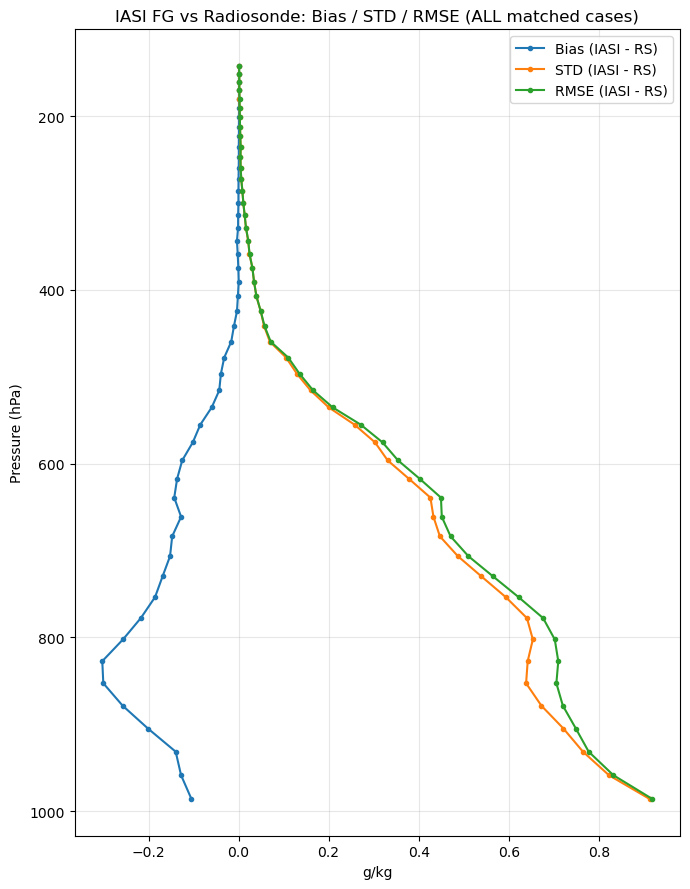

C:\Users\User\AppData\Local\Temp\ipykernel_2088\1751268035.py:205: RuntimeWarning: Mean of empty slice
  iasi_mean = np.nanmean(iasi_profiles_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_2088\1751268035.py:206: RuntimeWarning: Mean of empty slice
  rs_mean   = np.nanmean(rs_profiles_interp, axis=0)


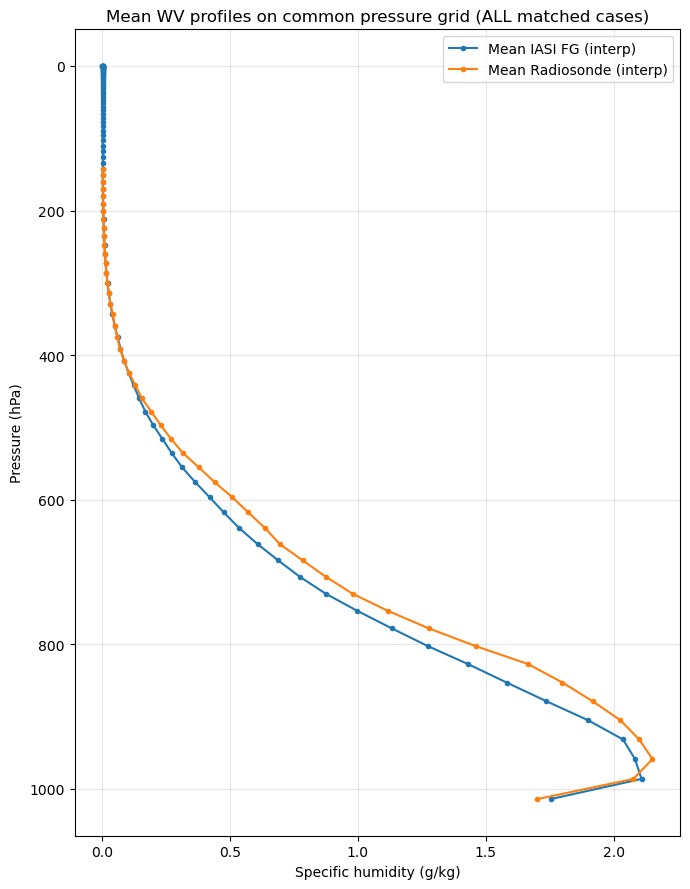

C:\Users\User\AppData\Local\Temp\ipykernel_2088\1751268035.py:222: RuntimeWarning: All-NaN slice encountered
  iasi_max = np.nanmax(iasi_profiles_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_2088\1751268035.py:223: RuntimeWarning: All-NaN slice encountered
  iasi_min = np.nanmin(iasi_profiles_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_2088\1751268035.py:224: RuntimeWarning: All-NaN slice encountered
  rs_max   = np.nanmax(rs_profiles_interp, axis=0)
C:\Users\User\AppData\Local\Temp\ipykernel_2088\1751268035.py:225: RuntimeWarning: All-NaN slice encountered
  rs_min   = np.nanmin(rs_profiles_interp, axis=0)


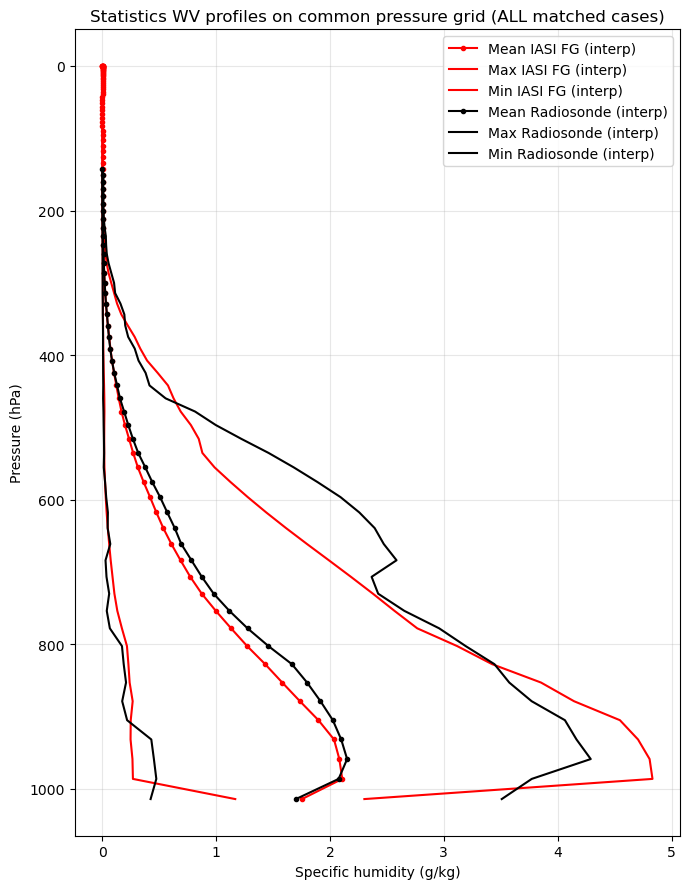

In [3]:
#  bias ============================================================
# ONE-CELL: Interpolate ALL matched IASI+Radiosonde WV profiles to a common pressure grid
#           then compute & plot RMSE profile (g/kg) vs pressure (hPa).
#
# REQUIREMENTS (must already exist from your earlier steps):
#   - df_match : DataFrame with columns ["iasi_index","radiosonde_index", ...] for ALL matches you want
#   - iasi     : xarray.Dataset opened from COMBINED_IASI_NYA_ALL275_CLEAN.nc (decode_times=True is fine)
#   - rs       : xarray.Dataset opened from rs_iop4h2o.nc (decode_times=False as you used)
#
# Assumptions for your files:
#   - IASI FG profile var name in combined file: "all_fgwv_profiles" (time, pressure_level)
#   - IASI pressure coordinate/var: "pressure_level" (1D) OR "all_pressure_profiles" (2D)
#   - RS variables: rs["q"] and rs["pres"] with dims ("launchtime","height")
#   - RS time dim is "launchtime" (as seen in your dataset)
# ============================================================
 
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
 
# ----------------------------
# Helpers (units + cleaning)
# ----------------------------
def pressure_to_hpa(p):
    p = np.asarray(p, dtype=float)
    # If in Pa (typical > 2000), convert to hPa
    if np.nanmedian(p[np.isfinite(p)]) > 2000:
        p = p / 100.0
    return p
 
def q_to_gpkg(q, units_attr=None):
    """
    Convert specific humidity to g/kg.
    Tries units attr; otherwise uses magnitude heuristics.
    """
    q = np.asarray(q, dtype=float)
 
    if units_attr is not None:
        u = str(units_attr).lower().replace(" ", "")
        if u in ["kg/kg", "kgkg-1", "kgkg^-1", "1"]:
            return q * 1000.0
        if u in ["g/kg", "gkg-1", "gkg^-1"]:
            return q
        if u in ["mg/kg", "mgkg-1", "mgkg^-1"]:
            return q / 1000.0
 
    finite = q[np.isfinite(q)]
    if finite.size == 0:
        return q
 
    med = np.nanmedian(np.abs(finite))
 
    # likely kg/kg (0.0001..0.05)
    if med < 0.2:
        return q * 1000.0
    # likely mg/kg (hundreds..tens of thousands)
    if med > 200:
        return q / 1000.0
    # likely already g/kg
    return q
 
def clean_and_sort(q_gpkg, p_hpa):
    q = np.asarray(q_gpkg, dtype=float)
    p = np.asarray(p_hpa, dtype=float)
 
    mask = np.isfinite(q) & np.isfinite(p) & (p > 0) & (p < 1100)
    q, p = q[mask], p[mask]
 
    # generous physical bounds (g/kg)
    mask2 = (q >= 0) & (q <= 50)
    q, p = q[mask2], p[mask2]
 
    # sort by pressure increasing for interp1d
    order = np.argsort(p)
    return q[order], p[order]
 
# ----------------------------
# 1) Choose IASI FG var + pressure grid
# ----------------------------
FG_VAR = "all_fgwv_profiles"
if FG_VAR not in iasi.data_vars:
    raise KeyError(f"Expected '{FG_VAR}' in IASI combined file. Found: {list(iasi.data_vars)}")
 
# Pressure grid: prefer 1D coord "pressure_level"
if "pressure_level" in iasi.coords:
    pressure_levels = iasi["pressure_level"].values
    pressure_levels_hpa = pressure_to_hpa(pressure_levels)
    pressure_kind = "1d_coord"
elif "pressure_level" in iasi.data_vars and np.ndim(iasi["pressure_level"].values) == 1:
    pressure_levels = iasi["pressure_level"].values
    pressure_levels_hpa = pressure_to_hpa(pressure_levels)
    pressure_kind = "1d_var"
elif "all_pressure_profiles" in iasi.data_vars:
    # 2D pressure profile stored per time; we will use the first matched case's pressure as the reference grid
    first_i = int(df_match.iloc[0]["iasi_index"])
    pressure_levels = iasi["all_pressure_profiles"].isel(time=first_i).values
    pressure_levels_hpa = pressure_to_hpa(pressure_levels)
    pressure_kind = "2d_profile_firstcase"
else:
    raise KeyError(
        "Could not find a pressure grid in IASI combined file. "
        "Tried: coord 'pressure_level', var 'pressure_level' (1D), var 'all_pressure_profiles'."
    )
 
# Ensure 1D
pressure_levels_hpa = np.asarray(pressure_levels_hpa, dtype=float).squeeze()
if pressure_levels_hpa.ndim != 1:
    raise ValueError(f"Pressure grid must be 1D. Got shape {pressure_levels_hpa.shape} via {pressure_kind}.")
 
# For interpolation: pressure must be monotonic increasing
p_ref = np.sort(pressure_levels_hpa)
 
# ----------------------------
# 2) Prepare output arrays
# ----------------------------
n_cases = len(df_match)
n_levels = len(p_ref)
 
iasi_profiles_interp = np.full((n_cases, n_levels), np.nan)
rs_profiles_interp   = np.full((n_cases, n_levels), np.nan)
 
units_iasi = iasi[FG_VAR].attrs.get("units", None)
units_rs   = rs["q"].attrs.get("units", None)
 
# Determine IASI time dimension name robustly
iasi_time_dim = iasi[FG_VAR].dims[0]  # usually "time"
 
# ----------------------------
# 3) Loop through ALL matches and interpolate
# ----------------------------
for k, row in df_match.reset_index(drop=True).iterrows():
    iasi_idx = int(row["iasi_index"])
    rs_idx   = int(row["radiosonde_index"])
 
    # --- IASI FG profile (g/kg) ---
    q_i_raw = iasi[FG_VAR].isel({iasi_time_dim: iasi_idx}).values.squeeze()
    q_i_gkg = q_to_gpkg(q_i_raw, units_attr=units_iasi)
 
    # Pressure for this IASI profile
    if "all_pressure_profiles" in iasi.data_vars:
        p_i_raw = iasi["all_pressure_profiles"].isel({iasi_time_dim: iasi_idx}).values.squeeze()
        p_i_hpa = pressure_to_hpa(p_i_raw)
    else:
        # use reference grid as the IASI grid directly (already p_ref)
        p_i_hpa = p_ref
 
    # If p_i_hpa is the same grid as p_ref (1D), no interp needed; but keep consistent
    if np.ndim(p_i_hpa) == 1 and p_i_hpa.shape[0] == q_i_gkg.shape[0]:
        q_i_sorted, p_i_sorted = clean_and_sort(q_i_gkg, p_i_hpa)
        f_i = interp1d(p_i_sorted, q_i_sorted, bounds_error=False, fill_value=np.nan)
        iasi_profiles_interp[k, :] = f_i(p_ref)
    else:
        # fallback: cannot safely interpret shapes
        raise ValueError(f"IASI pressure/profile shape mismatch at case {k}: p={np.shape(p_i_hpa)} q={np.shape(q_i_gkg)}")
 
    # --- Radiosonde profile (g/kg) ---
    q_r_raw = rs["q"].isel(launchtime=rs_idx).values
    p_r_raw = rs["pres"].isel(launchtime=rs_idx).values
 
    q_r_gkg = q_to_gpkg(q_r_raw, units_attr=units_rs)
    p_r_hpa = pressure_to_hpa(p_r_raw)
 
    q_r_sorted, p_r_sorted = clean_and_sort(q_r_gkg, p_r_hpa)
    f_r = interp1d(p_r_sorted, q_r_sorted, bounds_error=False, fill_value=np.nan)
    rs_profiles_interp[k, :] = f_r(p_ref)

###

index = np.where(iasi_profiles_interp[:,0]>0.4)
iasi_profiles_interp[index,:] = np.nan
 
# ----------------------------
# 4) Compute statistics (ALL matches)
# ----------------------------
diff = iasi_profiles_interp - rs_profiles_interp
 
bias_profile = np.nanmean(diff, axis=0)
std_profile  = np.nanstd(diff, axis=0)
rmse_profile = np.sqrt(np.nanmean(diff**2, axis=0))
 
# Quick sanity summary
print("✅ Interpolation done for ALL matches")
print("Cases (matches):", n_cases)
print("Vertical levels:", n_levels)
print("IASI units attr:", units_iasi, "| RS units attr:", units_rs)
print("RMSE min/max (g/kg):", np.nanmin(rmse_profile), np.nanmax(rmse_profile))
 
# ----------------------------
# 5) Plot: Bias / STD / RMSE vs pressure
# ----------------------------
plt.figure(figsize=(7, 9))
plt.plot(bias_profile, p_ref, "-o", markersize=3, label="Bias (IASI - RS)")
plt.plot(std_profile,  p_ref, "-o", markersize=3, label="STD (IASI - RS)")
plt.plot(rmse_profile, p_ref, "-o", markersize=3, label="RMSE (IASI - RS)")
plt.gca().invert_yaxis()
plt.xlabel("g/kg")
plt.ylabel("Pressure (hPa)")
plt.title("IASI FG vs Radiosonde: Bias / STD / RMSE (ALL matched cases)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
 
# Optional: mean profiles themselves (not differences)
iasi_mean = np.nanmean(iasi_profiles_interp, axis=0)
rs_mean   = np.nanmean(rs_profiles_interp, axis=0)
 
plt.figure(figsize=(7, 9))
plt.plot(iasi_mean, p_ref, "-o", markersize=3, label="Mean IASI FG (interp)")
plt.plot(rs_mean,   p_ref, "-o", markersize=3, label="Mean Radiosonde (interp)")
plt.gca().invert_yaxis()
plt.xlabel("Specific humidity (g/kg)")
plt.ylabel("Pressure (hPa)")
plt.title("Mean WV profiles on common pressure grid (ALL matched cases)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

###

iasi_max = np.nanmax(iasi_profiles_interp, axis=0)
iasi_min = np.nanmin(iasi_profiles_interp, axis=0)
rs_max   = np.nanmax(rs_profiles_interp, axis=0)
rs_min   = np.nanmin(rs_profiles_interp, axis=0)
 
plt.figure(figsize=(7, 9))
plt.plot(iasi_mean, p_ref, "-or", markersize=3, label="Mean IASI FG (interp)")
plt.plot(iasi_max, p_ref, "-r", markersize=3, label="Max IASI FG (interp)")
plt.plot(iasi_min, p_ref, "-r", markersize=3, label="Min IASI FG (interp)")
plt.plot(rs_mean,   p_ref, "-ok", markersize=3, label="Mean Radiosonde (interp)")
plt.plot(rs_max,   p_ref, "-k", markersize=3, label="Max Radiosonde (interp)")
plt.plot(rs_min,   p_ref, "-k", markersize=3, label="Min Radiosonde (interp)")
plt.gca().invert_yaxis()
plt.xlabel("Specific humidity (g/kg)")
plt.ylabel("Pressure (hPa)")
plt.title("Statistics WV profiles on common pressure grid (ALL matched cases)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

############### END ##############